In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                    labels=tf.zeros_like(gQs2))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    ##################################################### REPEAT 1
    next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
                                   reuse=True)
    next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
                                reuse=True)
    gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits,
                         action_size=action_size, reuse=True)
    gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
                                                                    labels=tf.zeros_like(gQs3))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
                                                                     labels=tf.ones_like(gQs3))) # 0-1
    ##################################################### REPEAT 2
    next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
                                   reuse=True)
    next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
                                reuse=True)
    gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits,
                         action_size=action_size, reuse=True)
    gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
                                                                    labels=tf.zeros_like(gQs3))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
                                                                     labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2, (1-dones)

In [8]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2, self.dones__ = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates == np.max(rates)]
            actions = actions[rates == np.max(rates)]
            next_states = next_states[rates == np.max(rates)]
            rewards = rewards[rates == np.max(rates)]
            dones = dones[rates == np.max(rates)]
            rates = rates[rates == np.max(rates)]
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            dloss, _ = sess.run([model.d_loss, model.d_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            #print(dones__, np.max(rates), rates.shape, dones)
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 rate:0.0280 aloss:1.3858 dloss:3.5442 aloss2:2.7283 exploreP:0.9986
Episode:1 meanR:19.0000 R:24.0000 rate:0.0480 aloss:1.3919 dloss:3.5237 aloss2:2.7479 exploreP:0.9962
Episode:2 meanR:25.6667 R:39.0000 rate:0.0780 aloss:1.3921 dloss:3.4992 aloss2:2.7626 exploreP:0.9924
Episode:3 meanR:25.5000 R:25.0000 rate:0.0500 aloss:1.3903 dloss:3.5097 aloss2:2.7531 exploreP:0.9900
Episode:4 meanR:26.2000 R:29.0000 rate:0.0580 aloss:1.3834 dloss:3.4550 aloss2:2.7978 exploreP:0.9871
Episode:5 meanR:23.8333 R:12.0000 rate:0.0240 aloss:1.3884 dloss:3.4658 aloss2:2.7834 exploreP:0.9859
Episode:6 meanR:22.1429 R:12.0000 rate:0.0240 aloss:1.3785 dloss:3.4860 aloss2:2.7691 exploreP:0.9848
Episode:7 meanR:31.3750 R:96.0000 rate:0.1920 aloss:1.3795 dloss:3.4311 aloss2:2.8109 exploreP:0.9755
Episode:8 meanR:31.5556 R:33.0000 rate:0.0660 aloss:1.3755 dloss:3.3838 aloss2:2.8474 exploreP:0.9723
Episode:9 meanR:33.9000 R:55.0000 rate:0.1100 aloss:1.3778 dloss:3.3717 aloss2:2.8

Episode:80 meanR:26.3210 R:27.0000 rate:0.0540 aloss:1.4092 dloss:1.7736 aloss2:5.1075 exploreP:0.8099
Episode:81 meanR:26.1829 R:15.0000 rate:0.0300 aloss:1.4404 dloss:1.7624 aloss2:5.1341 exploreP:0.8087
Episode:82 meanR:26.1325 R:22.0000 rate:0.0440 aloss:1.3968 dloss:1.7436 aloss2:5.1730 exploreP:0.8070
Episode:83 meanR:26.1190 R:25.0000 rate:0.0500 aloss:1.3967 dloss:1.7205 aloss2:5.2125 exploreP:0.8050
Episode:84 meanR:26.6706 R:73.0000 rate:0.1460 aloss:1.4025 dloss:1.6914 aloss2:5.2959 exploreP:0.7992
Episode:85 meanR:26.5233 R:14.0000 rate:0.0280 aloss:1.4011 dloss:1.6588 aloss2:5.3552 exploreP:0.7981
Episode:86 meanR:26.3448 R:11.0000 rate:0.0220 aloss:1.4871 dloss:1.6673 aloss2:5.3625 exploreP:0.7972
Episode:87 meanR:26.5455 R:44.0000 rate:0.0880 aloss:1.3664 dloss:1.6448 aloss2:5.4350 exploreP:0.7938
Episode:88 meanR:26.5281 R:25.0000 rate:0.0500 aloss:1.3705 dloss:1.5900 aloss2:5.5591 exploreP:0.7918
Episode:89 meanR:26.4111 R:16.0000 rate:0.0320 aloss:1.4365 dloss:1.5980 

Episode:159 meanR:32.4300 R:21.0000 rate:0.0420 aloss:1.3753 dloss:0.6863 aloss2:11.3689 exploreP:0.6224
Episode:160 meanR:32.2900 R:9.0000 rate:0.0180 aloss:1.3837 dloss:0.6345 aloss2:11.3842 exploreP:0.6218
Episode:161 meanR:32.0300 R:9.0000 rate:0.0180 aloss:1.3895 dloss:0.6794 aloss2:11.4277 exploreP:0.6212
Episode:162 meanR:32.0500 R:19.0000 rate:0.0380 aloss:1.4102 dloss:0.6512 aloss2:11.4432 exploreP:0.6201
Episode:163 meanR:31.9100 R:18.0000 rate:0.0360 aloss:1.4052 dloss:0.6595 aloss2:11.4429 exploreP:0.6190
Episode:164 meanR:32.0100 R:21.0000 rate:0.0420 aloss:1.3893 dloss:0.6769 aloss2:11.5179 exploreP:0.6177
Episode:165 meanR:31.8100 R:12.0000 rate:0.0240 aloss:1.4102 dloss:0.6997 aloss2:11.5468 exploreP:0.6170
Episode:166 meanR:31.7700 R:13.0000 rate:0.0260 aloss:1.4175 dloss:0.6668 aloss2:11.5750 exploreP:0.6162
Episode:167 meanR:31.6400 R:10.0000 rate:0.0200 aloss:1.3830 dloss:0.6257 aloss2:11.5873 exploreP:0.6156
Episode:168 meanR:31.4200 R:10.0000 rate:0.0200 aloss:1.3

Episode:238 meanR:16.9100 R:19.0000 rate:0.0380 aloss:1.3877 dloss:0.6501 aloss2:13.3238 exploreP:0.5506
Episode:239 meanR:16.6100 R:19.0000 rate:0.0380 aloss:1.3833 dloss:0.6738 aloss2:13.3795 exploreP:0.5496
Episode:240 meanR:16.4600 R:14.0000 rate:0.0280 aloss:1.3818 dloss:0.6074 aloss2:13.4217 exploreP:0.5488
Episode:241 meanR:16.2000 R:19.0000 rate:0.0380 aloss:1.3818 dloss:0.6106 aloss2:13.4114 exploreP:0.5478
Episode:242 meanR:15.7800 R:24.0000 rate:0.0480 aloss:1.3803 dloss:0.6900 aloss2:13.4279 exploreP:0.5465
Episode:243 meanR:15.8600 R:24.0000 rate:0.0480 aloss:1.3826 dloss:0.6518 aloss2:13.4434 exploreP:0.5452
Episode:244 meanR:15.9500 R:20.0000 rate:0.0400 aloss:1.3860 dloss:0.6425 aloss2:13.4652 exploreP:0.5442
Episode:245 meanR:16.2400 R:38.0000 rate:0.0760 aloss:1.3768 dloss:0.6559 aloss2:13.4905 exploreP:0.5421
Episode:246 meanR:16.3800 R:23.0000 rate:0.0460 aloss:1.3807 dloss:0.6398 aloss2:13.5460 exploreP:0.5409
Episode:247 meanR:16.4900 R:30.0000 rate:0.0600 aloss:1

Episode:317 meanR:15.9200 R:42.0000 rate:0.0840 aloss:1.3835 dloss:0.6477 aloss2:14.2811 exploreP:0.4879
Episode:318 meanR:16.1500 R:58.0000 rate:0.1160 aloss:1.3839 dloss:0.5994 aloss2:14.3084 exploreP:0.4851
Episode:319 meanR:16.1700 R:27.0000 rate:0.0540 aloss:1.3906 dloss:0.6888 aloss2:14.1464 exploreP:0.4839
Episode:320 meanR:16.1300 R:19.0000 rate:0.0380 aloss:1.3846 dloss:0.6394 aloss2:14.3453 exploreP:0.4830
Episode:321 meanR:16.1400 R:16.0000 rate:0.0320 aloss:1.3840 dloss:0.7074 aloss2:14.3404 exploreP:0.4822
Episode:322 meanR:16.0600 R:21.0000 rate:0.0420 aloss:1.3879 dloss:0.6836 aloss2:14.2043 exploreP:0.4812
Episode:323 meanR:16.1100 R:16.0000 rate:0.0320 aloss:1.3845 dloss:0.6944 aloss2:14.2860 exploreP:0.4805
Episode:324 meanR:16.1600 R:19.0000 rate:0.0380 aloss:1.3859 dloss:0.6291 aloss2:14.1981 exploreP:0.4796
Episode:325 meanR:16.1800 R:14.0000 rate:0.0280 aloss:1.3863 dloss:0.6912 aloss2:14.2780 exploreP:0.4789
Episode:326 meanR:16.2700 R:23.0000 rate:0.0460 aloss:1

Episode:395 meanR:26.8700 R:127.0000 rate:0.2540 aloss:1.3799 dloss:0.6414 aloss2:14.3574 exploreP:0.3873
Episode:396 meanR:27.8800 R:115.0000 rate:0.2300 aloss:1.3793 dloss:0.6750 aloss2:14.3748 exploreP:0.3830
Episode:397 meanR:29.1400 R:143.0000 rate:0.2860 aloss:1.3774 dloss:0.6902 aloss2:14.3193 exploreP:0.3777
Episode:398 meanR:29.4100 R:41.0000 rate:0.0820 aloss:1.3731 dloss:0.6469 aloss2:14.3315 exploreP:0.3762
Episode:399 meanR:30.5400 R:122.0000 rate:0.2440 aloss:1.3812 dloss:0.6957 aloss2:14.1988 exploreP:0.3718
Episode:400 meanR:32.0500 R:165.0000 rate:0.3300 aloss:1.3772 dloss:0.6892 aloss2:14.1418 exploreP:0.3658
Episode:401 meanR:33.0600 R:111.0000 rate:0.2220 aloss:1.3742 dloss:0.6866 aloss2:14.2387 exploreP:0.3619
Episode:402 meanR:33.2300 R:31.0000 rate:0.0620 aloss:1.3764 dloss:0.6891 aloss2:14.1786 exploreP:0.3608
Episode:403 meanR:34.6300 R:149.0000 rate:0.2980 aloss:1.3785 dloss:0.6831 aloss2:14.1476 exploreP:0.3556
Episode:404 meanR:35.7000 R:118.0000 rate:0.2360

Episode:473 meanR:55.0900 R:43.0000 rate:0.0860 aloss:1.3802 dloss:0.7180 aloss2:14.4927 exploreP:0.2551
Episode:474 meanR:55.1100 R:14.0000 rate:0.0280 aloss:1.3722 dloss:0.7237 aloss2:14.4154 exploreP:0.2548
Episode:475 meanR:55.0600 R:12.0000 rate:0.0240 aloss:1.3859 dloss:0.6503 aloss2:14.4851 exploreP:0.2545
Episode:476 meanR:55.0500 R:11.0000 rate:0.0220 aloss:1.3713 dloss:0.7034 aloss2:14.3776 exploreP:0.2542
Episode:477 meanR:56.0300 R:114.0000 rate:0.2280 aloss:1.3880 dloss:0.6747 aloss2:14.3948 exploreP:0.2515
Episode:478 meanR:56.0100 R:12.0000 rate:0.0240 aloss:1.3703 dloss:0.7067 aloss2:14.2986 exploreP:0.2512
Episode:479 meanR:55.9900 R:10.0000 rate:0.0200 aloss:1.3900 dloss:0.6496 aloss2:14.4363 exploreP:0.2509
Episode:480 meanR:55.9000 R:11.0000 rate:0.0220 aloss:1.3744 dloss:0.6596 aloss2:14.5161 exploreP:0.2507
Episode:481 meanR:55.8800 R:10.0000 rate:0.0200 aloss:1.4072 dloss:0.6251 aloss2:14.4679 exploreP:0.2504
Episode:482 meanR:55.7900 R:8.0000 rate:0.0160 aloss:1

Episode:552 meanR:21.5900 R:10.0000 rate:0.0200 aloss:1.4254 dloss:0.6361 aloss2:14.9043 exploreP:0.2173
Episode:553 meanR:21.5600 R:10.0000 rate:0.0200 aloss:1.4036 dloss:0.5804 aloss2:14.8628 exploreP:0.2171
Episode:554 meanR:21.5400 R:8.0000 rate:0.0160 aloss:1.3822 dloss:0.6911 aloss2:15.0273 exploreP:0.2170
Episode:555 meanR:21.4900 R:16.0000 rate:0.0320 aloss:1.4009 dloss:0.6336 aloss2:14.8743 exploreP:0.2166
Episode:556 meanR:21.5100 R:10.0000 rate:0.0200 aloss:1.4298 dloss:0.6115 aloss2:14.7496 exploreP:0.2164
Episode:557 meanR:21.5100 R:10.0000 rate:0.0200 aloss:1.4009 dloss:0.6934 aloss2:14.7997 exploreP:0.2162
Episode:558 meanR:21.5000 R:9.0000 rate:0.0180 aloss:1.4029 dloss:0.6433 aloss2:14.9430 exploreP:0.2160
Episode:559 meanR:21.4800 R:9.0000 rate:0.0180 aloss:1.3934 dloss:0.6222 aloss2:14.7616 exploreP:0.2158
Episode:560 meanR:22.6200 R:127.0000 rate:0.2540 aloss:1.3995 dloss:0.6628 aloss2:14.8278 exploreP:0.2132
Episode:561 meanR:23.6700 R:121.0000 rate:0.2420 aloss:1.

Episode:631 meanR:33.0000 R:9.0000 rate:0.0180 aloss:1.4419 dloss:0.5655 aloss2:15.2968 exploreP:0.1652
Episode:632 meanR:33.0100 R:10.0000 rate:0.0200 aloss:1.3879 dloss:0.7674 aloss2:15.1453 exploreP:0.1650
Episode:633 meanR:33.0100 R:10.0000 rate:0.0200 aloss:1.3686 dloss:0.8212 aloss2:14.8370 exploreP:0.1648
Episode:634 meanR:33.0700 R:14.0000 rate:0.0280 aloss:1.4213 dloss:0.6416 aloss2:15.0460 exploreP:0.1646
Episode:635 meanR:33.0500 R:9.0000 rate:0.0180 aloss:1.4244 dloss:0.6175 aloss2:14.9681 exploreP:0.1645
Episode:636 meanR:33.0800 R:12.0000 rate:0.0240 aloss:1.3984 dloss:0.6405 aloss2:14.9320 exploreP:0.1643
Episode:637 meanR:33.0900 R:10.0000 rate:0.0200 aloss:1.4076 dloss:0.7312 aloss2:14.8451 exploreP:0.1641
Episode:638 meanR:33.0500 R:12.0000 rate:0.0240 aloss:1.4144 dloss:0.6710 aloss2:14.9547 exploreP:0.1640
Episode:639 meanR:33.0600 R:10.0000 rate:0.0200 aloss:1.4162 dloss:0.6463 aloss2:14.9942 exploreP:0.1638
Episode:640 meanR:33.9000 R:94.0000 rate:0.1880 aloss:1.4

Episode:710 meanR:16.7600 R:18.0000 rate:0.0360 aloss:1.4125 dloss:0.7078 aloss2:15.1059 exploreP:0.1466
Episode:711 meanR:15.8800 R:9.0000 rate:0.0180 aloss:1.3943 dloss:0.7285 aloss2:15.1138 exploreP:0.1465
Episode:712 meanR:16.0300 R:26.0000 rate:0.0520 aloss:1.4141 dloss:0.6730 aloss2:15.0369 exploreP:0.1462
Episode:713 meanR:15.9800 R:9.0000 rate:0.0180 aloss:1.4322 dloss:0.6162 aloss2:14.9790 exploreP:0.1460
Episode:714 meanR:16.7100 R:84.0000 rate:0.1680 aloss:1.4195 dloss:0.6766 aloss2:14.9176 exploreP:0.1449
Episode:715 meanR:16.7200 R:10.0000 rate:0.0200 aloss:1.4114 dloss:0.6179 aloss2:14.8942 exploreP:0.1448
Episode:716 meanR:16.6900 R:10.0000 rate:0.0200 aloss:1.4153 dloss:0.6903 aloss2:15.2390 exploreP:0.1446
Episode:717 meanR:16.7000 R:10.0000 rate:0.0200 aloss:1.4034 dloss:0.7205 aloss2:15.1633 exploreP:0.1445
Episode:718 meanR:15.9300 R:8.0000 rate:0.0160 aloss:1.4091 dloss:0.5799 aloss2:15.1921 exploreP:0.1444
Episode:719 meanR:15.9300 R:10.0000 rate:0.0200 aloss:1.43

Episode:789 meanR:14.2900 R:15.0000 rate:0.0300 aloss:1.4226 dloss:0.7094 aloss2:15.2649 exploreP:0.1326
Episode:790 meanR:14.2900 R:10.0000 rate:0.0200 aloss:1.4784 dloss:0.6004 aloss2:14.9464 exploreP:0.1325
Episode:791 meanR:14.6100 R:42.0000 rate:0.0840 aloss:1.4064 dloss:0.6923 aloss2:15.1189 exploreP:0.1320
Episode:792 meanR:14.2900 R:9.0000 rate:0.0180 aloss:1.3929 dloss:0.6695 aloss2:15.2448 exploreP:0.1319
Episode:793 meanR:14.2900 R:10.0000 rate:0.0200 aloss:1.4268 dloss:0.5736 aloss2:15.1919 exploreP:0.1318
Episode:794 meanR:13.4800 R:10.0000 rate:0.0200 aloss:1.4147 dloss:0.7780 aloss2:15.1088 exploreP:0.1316
Episode:795 meanR:13.4700 R:9.0000 rate:0.0180 aloss:1.4006 dloss:0.6673 aloss2:15.0792 exploreP:0.1315
Episode:796 meanR:13.4500 R:9.0000 rate:0.0180 aloss:1.4060 dloss:0.6364 aloss2:15.1253 exploreP:0.1314
Episode:797 meanR:13.4500 R:10.0000 rate:0.0200 aloss:1.4429 dloss:0.6288 aloss2:15.0362 exploreP:0.1313
Episode:798 meanR:13.4700 R:12.0000 rate:0.0240 aloss:1.44

Episode:868 meanR:12.8600 R:13.0000 rate:0.0260 aloss:1.4020 dloss:0.6215 aloss2:15.3774 exploreP:0.1205
Episode:869 meanR:12.8800 R:11.0000 rate:0.0220 aloss:1.4273 dloss:0.7376 aloss2:15.2543 exploreP:0.1204
Episode:870 meanR:13.0200 R:24.0000 rate:0.0480 aloss:1.4125 dloss:0.6704 aloss2:15.4029 exploreP:0.1202
Episode:871 meanR:13.0600 R:13.0000 rate:0.0260 aloss:1.4080 dloss:0.6271 aloss2:15.4093 exploreP:0.1200
Episode:872 meanR:13.0700 R:10.0000 rate:0.0200 aloss:1.4019 dloss:0.7055 aloss2:15.1552 exploreP:0.1199
Episode:873 meanR:13.0400 R:9.0000 rate:0.0180 aloss:1.4148 dloss:0.5930 aloss2:15.4974 exploreP:0.1198
Episode:874 meanR:13.0500 R:13.0000 rate:0.0260 aloss:1.4056 dloss:0.5927 aloss2:15.2094 exploreP:0.1197
Episode:875 meanR:13.0100 R:9.0000 rate:0.0180 aloss:1.4364 dloss:0.5896 aloss2:15.4723 exploreP:0.1196
Episode:876 meanR:12.9900 R:10.0000 rate:0.0200 aloss:1.3992 dloss:0.6413 aloss2:15.6442 exploreP:0.1195
Episode:877 meanR:12.9700 R:9.0000 rate:0.0180 aloss:1.41

Episode:947 meanR:11.1500 R:12.0000 rate:0.0240 aloss:1.4328 dloss:0.7062 aloss2:15.0676 exploreP:0.1110
Episode:948 meanR:11.1500 R:10.0000 rate:0.0200 aloss:1.4032 dloss:0.6597 aloss2:15.3663 exploreP:0.1109
Episode:949 meanR:11.1300 R:9.0000 rate:0.0180 aloss:1.4227 dloss:0.6502 aloss2:15.4910 exploreP:0.1108
Episode:950 meanR:11.1400 R:10.0000 rate:0.0200 aloss:1.4130 dloss:0.6664 aloss2:15.1905 exploreP:0.1107
Episode:951 meanR:11.1200 R:8.0000 rate:0.0160 aloss:1.4311 dloss:0.7509 aloss2:15.4364 exploreP:0.1106
Episode:952 meanR:11.1000 R:10.0000 rate:0.0200 aloss:1.4088 dloss:0.6541 aloss2:15.5030 exploreP:0.1105
Episode:953 meanR:11.1100 R:9.0000 rate:0.0180 aloss:1.4106 dloss:0.6178 aloss2:15.4197 exploreP:0.1105
Episode:954 meanR:11.1000 R:11.0000 rate:0.0220 aloss:1.3909 dloss:0.6727 aloss2:15.4626 exploreP:0.1103
Episode:955 meanR:11.1000 R:9.0000 rate:0.0180 aloss:1.4002 dloss:0.6796 aloss2:15.4420 exploreP:0.1103
Episode:956 meanR:11.1000 R:8.0000 rate:0.0160 aloss:1.3991

Episode:1026 meanR:10.9300 R:12.0000 rate:0.0240 aloss:1.3933 dloss:0.6279 aloss2:15.6435 exploreP:0.1025
Episode:1027 meanR:10.8900 R:9.0000 rate:0.0180 aloss:1.4198 dloss:0.6222 aloss2:15.6747 exploreP:0.1024
Episode:1028 meanR:10.9000 R:10.0000 rate:0.0200 aloss:1.3885 dloss:0.6765 aloss2:15.7648 exploreP:0.1023
Episode:1029 meanR:10.9100 R:10.0000 rate:0.0200 aloss:1.4510 dloss:0.6529 aloss2:15.6783 exploreP:0.1022
Episode:1030 meanR:10.9000 R:9.0000 rate:0.0180 aloss:1.4063 dloss:0.5880 aloss2:15.7527 exploreP:0.1022
Episode:1031 meanR:10.8900 R:10.0000 rate:0.0200 aloss:1.4557 dloss:0.5228 aloss2:15.5995 exploreP:0.1021
Episode:1032 meanR:10.9200 R:11.0000 rate:0.0220 aloss:1.4124 dloss:0.5864 aloss2:15.5974 exploreP:0.1020
Episode:1033 meanR:10.9500 R:11.0000 rate:0.0220 aloss:1.4106 dloss:0.6821 aloss2:15.7258 exploreP:0.1019
Episode:1034 meanR:10.9600 R:12.0000 rate:0.0240 aloss:1.4362 dloss:0.6955 aloss2:15.8294 exploreP:0.1018
Episode:1035 meanR:10.9600 R:10.0000 rate:0.0200

Episode:1104 meanR:10.2000 R:9.0000 rate:0.0180 aloss:1.4274 dloss:0.6405 aloss2:15.5559 exploreP:0.0957
Episode:1105 meanR:10.1800 R:10.0000 rate:0.0200 aloss:1.5000 dloss:0.5350 aloss2:15.6547 exploreP:0.0956
Episode:1106 meanR:10.1800 R:10.0000 rate:0.0200 aloss:1.4051 dloss:0.5681 aloss2:15.7905 exploreP:0.0955
Episode:1107 meanR:10.1500 R:9.0000 rate:0.0180 aloss:1.4338 dloss:0.5420 aloss2:15.7449 exploreP:0.0954
Episode:1108 meanR:10.1400 R:9.0000 rate:0.0180 aloss:1.4301 dloss:0.6205 aloss2:15.7925 exploreP:0.0953
Episode:1109 meanR:10.1100 R:9.0000 rate:0.0180 aloss:1.4007 dloss:0.6386 aloss2:15.9146 exploreP:0.0953
Episode:1110 meanR:10.0900 R:9.0000 rate:0.0180 aloss:1.4210 dloss:0.5839 aloss2:15.8053 exploreP:0.0952
Episode:1111 meanR:10.0600 R:9.0000 rate:0.0180 aloss:1.3908 dloss:0.7611 aloss2:15.9140 exploreP:0.0951
Episode:1112 meanR:10.0800 R:11.0000 rate:0.0220 aloss:1.4142 dloss:0.6175 aloss2:15.9238 exploreP:0.0950
Episode:1113 meanR:10.0700 R:8.0000 rate:0.0160 alos

Episode:1182 meanR:10.4300 R:10.0000 rate:0.0200 aloss:1.4092 dloss:0.6631 aloss2:15.6636 exploreP:0.0889
Episode:1183 meanR:10.4100 R:8.0000 rate:0.0160 aloss:1.4042 dloss:0.5551 aloss2:15.7483 exploreP:0.0888
Episode:1184 meanR:10.3800 R:8.0000 rate:0.0160 aloss:1.4304 dloss:0.5962 aloss2:15.6477 exploreP:0.0887
Episode:1185 meanR:10.4000 R:10.0000 rate:0.0200 aloss:1.3899 dloss:0.7170 aloss2:15.3958 exploreP:0.0887
Episode:1186 meanR:10.4000 R:9.0000 rate:0.0180 aloss:1.4113 dloss:0.7046 aloss2:15.6687 exploreP:0.0886
Episode:1187 meanR:10.3800 R:10.0000 rate:0.0200 aloss:1.4340 dloss:0.5998 aloss2:15.7502 exploreP:0.0885
Episode:1188 meanR:10.3800 R:10.0000 rate:0.0200 aloss:1.4061 dloss:0.6148 aloss2:16.0249 exploreP:0.0884
Episode:1189 meanR:10.3700 R:10.0000 rate:0.0200 aloss:1.4298 dloss:0.6786 aloss2:15.5789 exploreP:0.0884
Episode:1190 meanR:10.4000 R:12.0000 rate:0.0240 aloss:1.4003 dloss:0.6250 aloss2:15.7912 exploreP:0.0883
Episode:1191 meanR:10.4100 R:9.0000 rate:0.0180 a

Episode:1260 meanR:9.8300 R:10.0000 rate:0.0200 aloss:1.4022 dloss:0.6557 aloss2:15.4897 exploreP:0.0830
Episode:1261 meanR:9.8100 R:9.0000 rate:0.0180 aloss:1.4106 dloss:0.6143 aloss2:15.6877 exploreP:0.0830
Episode:1262 meanR:9.8100 R:9.0000 rate:0.0180 aloss:1.4133 dloss:0.6682 aloss2:15.5153 exploreP:0.0829
Episode:1263 meanR:9.7900 R:9.0000 rate:0.0180 aloss:1.4176 dloss:0.6203 aloss2:15.9409 exploreP:0.0828
Episode:1264 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.4021 dloss:0.5967 aloss2:15.9534 exploreP:0.0828
Episode:1265 meanR:9.8200 R:12.0000 rate:0.0240 aloss:1.4225 dloss:0.6608 aloss2:15.8085 exploreP:0.0827
Episode:1266 meanR:9.8200 R:12.0000 rate:0.0240 aloss:1.4019 dloss:0.7808 aloss2:15.6442 exploreP:0.0826
Episode:1267 meanR:9.8400 R:12.0000 rate:0.0240 aloss:1.4370 dloss:0.7166 aloss2:15.6660 exploreP:0.0825
Episode:1268 meanR:9.8400 R:10.0000 rate:0.0200 aloss:1.3874 dloss:0.6951 aloss2:15.2726 exploreP:0.0824
Episode:1269 meanR:9.8300 R:10.0000 rate:0.0200 aloss:1.40

Episode:1338 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.4087 dloss:0.7060 aloss2:15.9399 exploreP:0.0775
Episode:1339 meanR:10.0100 R:10.0000 rate:0.0200 aloss:1.4028 dloss:0.6422 aloss2:16.2236 exploreP:0.0775
Episode:1340 meanR:10.0100 R:10.0000 rate:0.0200 aloss:1.3996 dloss:0.7093 aloss2:15.9810 exploreP:0.0774
Episode:1341 meanR:10.0200 R:10.0000 rate:0.0200 aloss:1.4130 dloss:0.6054 aloss2:15.3144 exploreP:0.0773
Episode:1342 meanR:10.0100 R:9.0000 rate:0.0180 aloss:1.4188 dloss:0.6178 aloss2:15.9268 exploreP:0.0773
Episode:1343 meanR:10.0000 R:11.0000 rate:0.0220 aloss:1.4173 dloss:0.6835 aloss2:15.7402 exploreP:0.0772
Episode:1344 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.3957 dloss:0.7113 aloss2:15.9074 exploreP:0.0771
Episode:1345 meanR:9.9900 R:10.0000 rate:0.0200 aloss:1.4278 dloss:0.5991 aloss2:15.8576 exploreP:0.0771
Episode:1346 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.4591 dloss:0.6620 aloss2:15.6498 exploreP:0.0770
Episode:1347 meanR:9.9900 R:8.0000 rate:0.0160 a

Episode:1417 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.4107 dloss:0.7241 aloss2:16.0676 exploreP:0.0726
Episode:1418 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.3956 dloss:0.6941 aloss2:16.3223 exploreP:0.0726
Episode:1419 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.4059 dloss:0.7564 aloss2:15.1699 exploreP:0.0725
Episode:1420 meanR:9.5800 R:11.0000 rate:0.0220 aloss:1.3792 dloss:0.6049 aloss2:16.0974 exploreP:0.0724
Episode:1421 meanR:9.5900 R:11.0000 rate:0.0220 aloss:1.4174 dloss:0.6658 aloss2:16.0490 exploreP:0.0724
Episode:1422 meanR:9.5800 R:8.0000 rate:0.0160 aloss:1.4003 dloss:0.6754 aloss2:16.0390 exploreP:0.0723
Episode:1423 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.3765 dloss:0.6200 aloss2:16.0623 exploreP:0.0723
Episode:1424 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.4098 dloss:0.6385 aloss2:16.3795 exploreP:0.0722
Episode:1425 meanR:9.5700 R:11.0000 rate:0.0220 aloss:1.4229 dloss:0.6463 aloss2:16.1528 exploreP:0.0721
Episode:1426 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.429

Episode:1496 meanR:9.7800 R:9.0000 rate:0.0180 aloss:1.4235 dloss:0.8027 aloss2:16.0614 exploreP:0.0680
Episode:1497 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.4174 dloss:0.6569 aloss2:16.1435 exploreP:0.0679
Episode:1498 meanR:9.7600 R:9.0000 rate:0.0180 aloss:1.4203 dloss:0.5645 aloss2:16.0531 exploreP:0.0679
Episode:1499 meanR:9.7800 R:10.0000 rate:0.0200 aloss:1.4171 dloss:0.7550 aloss2:16.1281 exploreP:0.0678
Episode:1500 meanR:9.8100 R:12.0000 rate:0.0240 aloss:1.4141 dloss:0.5765 aloss2:16.1083 exploreP:0.0677
Episode:1501 meanR:9.8000 R:8.0000 rate:0.0160 aloss:1.3827 dloss:0.5461 aloss2:16.0528 exploreP:0.0677
Episode:1502 meanR:9.8000 R:9.0000 rate:0.0180 aloss:1.4204 dloss:0.8191 aloss2:16.1134 exploreP:0.0676
Episode:1503 meanR:9.7900 R:9.0000 rate:0.0180 aloss:1.4132 dloss:0.6944 aloss2:15.9510 exploreP:0.0676
Episode:1504 meanR:9.8100 R:12.0000 rate:0.0240 aloss:1.3966 dloss:0.6589 aloss2:15.8736 exploreP:0.0675
Episode:1505 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.4552 

Episode:1575 meanR:9.7000 R:10.0000 rate:0.0200 aloss:1.4423 dloss:0.6854 aloss2:16.3330 exploreP:0.0637
Episode:1576 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.4156 dloss:0.7090 aloss2:15.8792 exploreP:0.0636
Episode:1577 meanR:9.6900 R:10.0000 rate:0.0200 aloss:1.4420 dloss:0.6743 aloss2:16.2106 exploreP:0.0636
Episode:1578 meanR:9.6900 R:11.0000 rate:0.0220 aloss:1.4198 dloss:0.6124 aloss2:16.3983 exploreP:0.0635
Episode:1579 meanR:9.6900 R:10.0000 rate:0.0200 aloss:1.4255 dloss:0.7205 aloss2:16.4816 exploreP:0.0635
Episode:1580 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.4154 dloss:0.6911 aloss2:16.3966 exploreP:0.0634
Episode:1581 meanR:9.7000 R:9.0000 rate:0.0180 aloss:1.3923 dloss:0.7114 aloss2:16.1836 exploreP:0.0634
Episode:1582 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.4620 dloss:0.7136 aloss2:15.7731 exploreP:0.0633
Episode:1583 meanR:9.7100 R:10.0000 rate:0.0200 aloss:1.4095 dloss:0.6173 aloss2:16.1275 exploreP:0.0633
Episode:1584 meanR:9.7200 R:10.0000 rate:0.0200 aloss:1.376

Episode:1654 meanR:9.7100 R:9.0000 rate:0.0180 aloss:1.4399 dloss:0.6199 aloss2:16.3538 exploreP:0.0597
Episode:1655 meanR:9.7000 R:9.0000 rate:0.0180 aloss:1.3908 dloss:0.8056 aloss2:16.2496 exploreP:0.0597
Episode:1656 meanR:9.6800 R:9.0000 rate:0.0180 aloss:1.3628 dloss:0.7107 aloss2:15.9794 exploreP:0.0596
Episode:1657 meanR:9.6800 R:9.0000 rate:0.0180 aloss:1.4297 dloss:0.6399 aloss2:16.1526 exploreP:0.0596
Episode:1658 meanR:9.6800 R:10.0000 rate:0.0200 aloss:1.4039 dloss:0.5851 aloss2:15.9092 exploreP:0.0595
Episode:1659 meanR:9.6800 R:10.0000 rate:0.0200 aloss:1.4397 dloss:0.7140 aloss2:16.1009 exploreP:0.0595
Episode:1660 meanR:9.6800 R:9.0000 rate:0.0180 aloss:1.4208 dloss:0.6526 aloss2:16.1335 exploreP:0.0594
Episode:1661 meanR:9.6500 R:9.0000 rate:0.0180 aloss:1.4120 dloss:0.8158 aloss2:16.2471 exploreP:0.0594
Episode:1662 meanR:9.6200 R:8.0000 rate:0.0160 aloss:1.4104 dloss:0.6130 aloss2:16.1864 exploreP:0.0594
Episode:1663 meanR:9.6300 R:11.0000 rate:0.0220 aloss:1.4289 d

Episode:1733 meanR:9.6300 R:9.0000 rate:0.0180 aloss:1.4437 dloss:0.7028 aloss2:16.2509 exploreP:0.0561
Episode:1734 meanR:9.6300 R:9.0000 rate:0.0180 aloss:1.4215 dloss:0.5488 aloss2:16.5676 exploreP:0.0560
Episode:1735 meanR:9.6400 R:11.0000 rate:0.0220 aloss:1.4297 dloss:0.6050 aloss2:16.5390 exploreP:0.0560
Episode:1736 meanR:9.6600 R:10.0000 rate:0.0200 aloss:1.3991 dloss:0.5805 aloss2:16.4580 exploreP:0.0559
Episode:1737 meanR:9.6700 R:10.0000 rate:0.0200 aloss:1.4232 dloss:0.6301 aloss2:16.6441 exploreP:0.0559
Episode:1738 meanR:9.6700 R:9.0000 rate:0.0180 aloss:1.4258 dloss:0.6316 aloss2:16.4130 exploreP:0.0558
Episode:1739 meanR:9.6900 R:10.0000 rate:0.0200 aloss:1.4385 dloss:0.6230 aloss2:16.4216 exploreP:0.0558
Episode:1740 meanR:9.7000 R:10.0000 rate:0.0200 aloss:1.4227 dloss:0.5936 aloss2:16.5343 exploreP:0.0557
Episode:1741 meanR:9.7000 R:10.0000 rate:0.0200 aloss:1.4224 dloss:0.6224 aloss2:16.4421 exploreP:0.0557
Episode:1742 meanR:9.6800 R:10.0000 rate:0.0200 aloss:1.44

Episode:1812 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.4232 dloss:0.6811 aloss2:16.3540 exploreP:0.0527
Episode:1813 meanR:9.5600 R:11.0000 rate:0.0220 aloss:1.4080 dloss:0.5990 aloss2:16.6010 exploreP:0.0527
Episode:1814 meanR:9.5500 R:8.0000 rate:0.0160 aloss:1.4529 dloss:0.6933 aloss2:16.6092 exploreP:0.0526
Episode:1815 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.4467 dloss:0.6687 aloss2:16.3927 exploreP:0.0526
Episode:1816 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.3733 dloss:0.7086 aloss2:16.4377 exploreP:0.0525
Episode:1817 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.4024 dloss:0.6439 aloss2:16.3815 exploreP:0.0525
Episode:1818 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.4306 dloss:0.5365 aloss2:16.2426 exploreP:0.0525
Episode:1819 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.4317 dloss:0.6399 aloss2:16.6724 exploreP:0.0524
Episode:1820 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.4227 dloss:0.5983 aloss2:16.6045 exploreP:0.0524
Episode:1821 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.46

Episode:1891 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.3519 dloss:0.6140 aloss2:15.8576 exploreP:0.0495
Episode:1892 meanR:9.6500 R:12.0000 rate:0.0240 aloss:1.3851 dloss:0.7203 aloss2:16.2355 exploreP:0.0495
Episode:1893 meanR:9.6500 R:9.0000 rate:0.0180 aloss:1.4423 dloss:0.6975 aloss2:16.3672 exploreP:0.0495
Episode:1894 meanR:9.6400 R:9.0000 rate:0.0180 aloss:1.4417 dloss:0.8271 aloss2:16.2891 exploreP:0.0494
Episode:1895 meanR:9.6600 R:10.0000 rate:0.0200 aloss:1.3867 dloss:0.5700 aloss2:15.9536 exploreP:0.0494
Episode:1896 meanR:9.6600 R:10.0000 rate:0.0200 aloss:1.4207 dloss:0.7687 aloss2:16.0524 exploreP:0.0493
Episode:1897 meanR:9.6600 R:9.0000 rate:0.0180 aloss:1.4254 dloss:0.6389 aloss2:16.2723 exploreP:0.0493
Episode:1898 meanR:9.6400 R:9.0000 rate:0.0180 aloss:1.3843 dloss:0.6226 aloss2:15.6850 exploreP:0.0493
Episode:1899 meanR:9.6400 R:9.0000 rate:0.0180 aloss:1.4191 dloss:0.6858 aloss2:16.0997 exploreP:0.0492
Episode:1900 meanR:9.6500 R:10.0000 rate:0.0200 aloss:1.4112

Episode:1970 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.3953 dloss:0.6571 aloss2:16.5530 exploreP:0.0466
Episode:1971 meanR:9.8300 R:10.0000 rate:0.0200 aloss:1.4352 dloss:0.7245 aloss2:16.2294 exploreP:0.0466
Episode:1972 meanR:9.8400 R:9.0000 rate:0.0180 aloss:1.4355 dloss:0.7723 aloss2:16.0930 exploreP:0.0465
Episode:1973 meanR:9.8300 R:9.0000 rate:0.0180 aloss:1.4172 dloss:0.7415 aloss2:16.5641 exploreP:0.0465
Episode:1974 meanR:9.8300 R:9.0000 rate:0.0180 aloss:1.3703 dloss:0.5885 aloss2:16.0599 exploreP:0.0465
Episode:1975 meanR:9.8200 R:9.0000 rate:0.0180 aloss:1.4421 dloss:0.7151 aloss2:16.2528 exploreP:0.0464
Episode:1976 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.4552 dloss:0.6925 aloss2:16.2697 exploreP:0.0464
Episode:1977 meanR:9.8100 R:10.0000 rate:0.0200 aloss:1.4916 dloss:0.6066 aloss2:16.1507 exploreP:0.0464
Episode:1978 meanR:9.8000 R:9.0000 rate:0.0180 aloss:1.3870 dloss:0.6898 aloss2:16.1649 exploreP:0.0463
Episode:1979 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.3407

Episode:2049 meanR:9.6000 R:12.0000 rate:0.0240 aloss:1.4257 dloss:0.6651 aloss2:16.6187 exploreP:0.0439
Episode:2050 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.5367 dloss:0.6540 aloss2:16.4038 exploreP:0.0439
Episode:2051 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.3143 dloss:0.6086 aloss2:16.7360 exploreP:0.0439
Episode:2052 meanR:9.6000 R:9.0000 rate:0.0180 aloss:1.3707 dloss:0.5382 aloss2:16.7613 exploreP:0.0438
Episode:2053 meanR:9.6000 R:9.0000 rate:0.0180 aloss:1.4333 dloss:0.6536 aloss2:16.7624 exploreP:0.0438
Episode:2054 meanR:9.6200 R:11.0000 rate:0.0220 aloss:1.4378 dloss:0.6718 aloss2:17.0153 exploreP:0.0438
Episode:2055 meanR:9.6100 R:9.0000 rate:0.0180 aloss:1.4477 dloss:0.7121 aloss2:16.8215 exploreP:0.0437
Episode:2056 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.4460 dloss:0.6227 aloss2:16.6348 exploreP:0.0437
Episode:2057 meanR:9.5900 R:9.0000 rate:0.0180 aloss:1.4427 dloss:0.6588 aloss2:16.8325 exploreP:0.0437
Episode:2058 meanR:9.5800 R:9.0000 rate:0.0180 aloss:1.3673

Episode:2128 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.4086 dloss:0.6034 aloss2:16.5065 exploreP:0.0414
Episode:2129 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.3199 dloss:0.6178 aloss2:16.4276 exploreP:0.0414
Episode:2130 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.4318 dloss:0.6093 aloss2:16.6814 exploreP:0.0414
Episode:2131 meanR:9.6700 R:10.0000 rate:0.0200 aloss:1.3983 dloss:0.5751 aloss2:16.8608 exploreP:0.0413
Episode:2132 meanR:9.6800 R:10.0000 rate:0.0200 aloss:1.4544 dloss:0.5971 aloss2:16.8694 exploreP:0.0413
Episode:2133 meanR:9.7100 R:12.0000 rate:0.0240 aloss:1.4023 dloss:0.6204 aloss2:16.2460 exploreP:0.0413
Episode:2134 meanR:9.7000 R:10.0000 rate:0.0200 aloss:1.3207 dloss:0.6003 aloss2:16.7070 exploreP:0.0412
Episode:2135 meanR:9.6800 R:8.0000 rate:0.0160 aloss:1.4505 dloss:0.7309 aloss2:16.9994 exploreP:0.0412
Episode:2136 meanR:9.6900 R:10.0000 rate:0.0200 aloss:1.4384 dloss:0.7079 aloss2:16.7132 exploreP:0.0412
Episode:2137 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.4237

Episode:2207 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.4567 dloss:0.6298 aloss2:16.8347 exploreP:0.0392
Episode:2208 meanR:9.3300 R:13.0000 rate:0.0260 aloss:1.4332 dloss:0.7888 aloss2:16.5254 exploreP:0.0392
Episode:2209 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.3851 dloss:0.8122 aloss2:16.6165 exploreP:0.0391
Episode:2210 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.4334 dloss:0.6262 aloss2:16.4675 exploreP:0.0391
Episode:2211 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.4645 dloss:0.6964 aloss2:15.5985 exploreP:0.0391
Episode:2212 meanR:9.3300 R:8.0000 rate:0.0160 aloss:1.4459 dloss:0.6129 aloss2:16.3525 exploreP:0.0391
Episode:2213 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.4523 dloss:0.5913 aloss2:16.1815 exploreP:0.0390
Episode:2214 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.3990 dloss:0.6267 aloss2:16.6675 exploreP:0.0390
Episode:2215 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.4130 dloss:0.5613 aloss2:16.4727 exploreP:0.0390
Episode:2216 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.455

Episode:2286 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.3480 dloss:0.7062 aloss2:16.3594 exploreP:0.0371
Episode:2287 meanR:9.5200 R:8.0000 rate:0.0160 aloss:1.3043 dloss:0.7310 aloss2:16.1982 exploreP:0.0371
Episode:2288 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.4554 dloss:0.7357 aloss2:16.6585 exploreP:0.0370
Episode:2289 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.3730 dloss:0.6588 aloss2:16.5400 exploreP:0.0370
Episode:2290 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.4040 dloss:0.5358 aloss2:16.6028 exploreP:0.0370
Episode:2291 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.4357 dloss:0.6384 aloss2:16.6596 exploreP:0.0370
Episode:2292 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.4195 dloss:0.7513 aloss2:16.7716 exploreP:0.0369
Episode:2293 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.3949 dloss:0.6951 aloss2:16.2584 exploreP:0.0369
Episode:2294 meanR:9.5300 R:8.0000 rate:0.0160 aloss:1.4222 dloss:0.5689 aloss2:16.1691 exploreP:0.0369
Episode:2295 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.4097

Episode:2365 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.3707 dloss:0.6485 aloss2:16.4720 exploreP:0.0351
Episode:2366 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.4544 dloss:0.5982 aloss2:16.5084 exploreP:0.0351
Episode:2367 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.3392 dloss:0.5620 aloss2:16.4047 exploreP:0.0351
Episode:2368 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.4154 dloss:0.6508 aloss2:16.7189 exploreP:0.0351
Episode:2369 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.4049 dloss:0.6420 aloss2:16.8680 exploreP:0.0350
Episode:2370 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.4030 dloss:0.6483 aloss2:16.4512 exploreP:0.0350
Episode:2371 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.4078 dloss:0.5839 aloss2:16.6366 exploreP:0.0350
Episode:2372 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.3938 dloss:0.5857 aloss2:16.5861 exploreP:0.0350
Episode:2373 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.3816 dloss:0.6801 aloss2:16.7189 exploreP:0.0349
Episode:2374 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.415

Episode:2444 meanR:9.5100 R:8.0000 rate:0.0160 aloss:1.4415 dloss:0.7771 aloss2:16.3533 exploreP:0.0333
Episode:2445 meanR:9.5200 R:11.0000 rate:0.0220 aloss:1.4057 dloss:0.6752 aloss2:16.5026 exploreP:0.0333
Episode:2446 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.3057 dloss:0.5877 aloss2:16.7504 exploreP:0.0333
Episode:2447 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.4425 dloss:0.5942 aloss2:16.6487 exploreP:0.0332
Episode:2448 meanR:9.5300 R:12.0000 rate:0.0240 aloss:1.2871 dloss:0.5372 aloss2:16.3349 exploreP:0.0332
Episode:2449 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.4198 dloss:0.7941 aloss2:16.7448 exploreP:0.0332
Episode:2450 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.3947 dloss:0.5932 aloss2:16.2276 exploreP:0.0332
Episode:2451 meanR:9.5000 R:8.0000 rate:0.0160 aloss:1.4471 dloss:0.6374 aloss2:16.3980 exploreP:0.0331
Episode:2452 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.4036 dloss:0.6459 aloss2:16.8010 exploreP:0.0331
Episode:2453 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.4527 d

Episode:2523 meanR:9.4600 R:8.0000 rate:0.0160 aloss:1.4319 dloss:0.7156 aloss2:16.7585 exploreP:0.0316
Episode:2524 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.3618 dloss:0.5755 aloss2:16.4757 exploreP:0.0316
Episode:2525 meanR:9.4900 R:11.0000 rate:0.0220 aloss:1.3587 dloss:0.6855 aloss2:16.5461 exploreP:0.0316
Episode:2526 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.3636 dloss:0.5404 aloss2:16.5395 exploreP:0.0316
Episode:2527 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.3878 dloss:0.6318 aloss2:16.6254 exploreP:0.0315
Episode:2528 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.3937 dloss:0.7516 aloss2:16.5816 exploreP:0.0315
Episode:2529 meanR:9.4600 R:8.0000 rate:0.0160 aloss:1.4265 dloss:0.5795 aloss2:16.4579 exploreP:0.0315
Episode:2530 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.3902 dloss:0.6403 aloss2:16.4113 exploreP:0.0315
Episode:2531 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.4479 dloss:0.6282 aloss2:16.3313 exploreP:0.0315
Episode:2532 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.3726 

Episode:2602 meanR:9.5300 R:8.0000 rate:0.0160 aloss:1.4610 dloss:0.6091 aloss2:16.4233 exploreP:0.0301
Episode:2603 meanR:9.5500 R:11.0000 rate:0.0220 aloss:1.3969 dloss:0.6386 aloss2:16.7441 exploreP:0.0300
Episode:2604 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.4563 dloss:0.7241 aloss2:16.6112 exploreP:0.0300
Episode:2605 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.2931 dloss:0.6124 aloss2:16.5341 exploreP:0.0300
Episode:2606 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.3723 dloss:0.5544 aloss2:16.4053 exploreP:0.0300
Episode:2607 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.4501 dloss:0.6363 aloss2:16.4762 exploreP:0.0300
Episode:2608 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.4187 dloss:0.6108 aloss2:16.4175 exploreP:0.0299
Episode:2609 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.3397 dloss:0.6538 aloss2:16.7697 exploreP:0.0299
Episode:2610 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.4447 dloss:0.6851 aloss2:16.3997 exploreP:0.0299
Episode:2611 meanR:9.5200 R:8.0000 rate:0.0160 aloss:1.4496 

Episode:2681 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.3066 dloss:0.5764 aloss2:16.4325 exploreP:0.0286
Episode:2682 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.3994 dloss:0.6666 aloss2:15.9759 exploreP:0.0286
Episode:2683 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.3142 dloss:0.6253 aloss2:16.8035 exploreP:0.0286
Episode:2684 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.2840 dloss:0.5057 aloss2:16.5829 exploreP:0.0286
Episode:2685 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.3597 dloss:0.5891 aloss2:16.4593 exploreP:0.0286
Episode:2686 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.3851 dloss:0.5816 aloss2:16.5419 exploreP:0.0285
Episode:2687 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.4570 dloss:0.7546 aloss2:16.7271 exploreP:0.0285
Episode:2688 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.4415 dloss:0.7816 aloss2:16.6611 exploreP:0.0285
Episode:2689 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.4131 dloss:0.7350 aloss2:16.4832 exploreP:0.0285
Episode:2690 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.3834 dlo

Episode:2760 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.3018 dloss:0.5417 aloss2:16.4230 exploreP:0.0273
Episode:2761 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.4087 dloss:0.5712 aloss2:16.6910 exploreP:0.0273
Episode:2762 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.4515 dloss:0.6535 aloss2:16.6144 exploreP:0.0273
Episode:2763 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.3512 dloss:0.6768 aloss2:16.7899 exploreP:0.0272
Episode:2764 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.3939 dloss:0.6535 aloss2:16.6052 exploreP:0.0272
Episode:2765 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.3933 dloss:0.6384 aloss2:16.6128 exploreP:0.0272
Episode:2766 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.4371 dloss:0.6010 aloss2:16.7870 exploreP:0.0272
Episode:2767 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.4492 dloss:0.6051 aloss2:16.3062 exploreP:0.0272
Episode:2768 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.4087 dloss:0.6721 aloss2:16.6567 exploreP:0.0272
Episode:2769 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.442

Episode:2839 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.4286 dloss:0.6070 aloss2:16.7087 exploreP:0.0260
Episode:2840 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.3231 dloss:0.5632 aloss2:16.6765 exploreP:0.0260
Episode:2841 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.3105 dloss:0.5254 aloss2:16.7235 exploreP:0.0260
Episode:2842 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.3343 dloss:0.5779 aloss2:16.4476 exploreP:0.0260
Episode:2843 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.4552 dloss:0.7018 aloss2:16.6532 exploreP:0.0260
Episode:2844 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.2926 dloss:0.5573 aloss2:16.6182 exploreP:0.0260
Episode:2845 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.2963 dloss:0.6687 aloss2:16.7814 exploreP:0.0259
Episode:2846 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.4495 dloss:0.7311 aloss2:16.9082 exploreP:0.0259
Episode:2847 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.4464 dloss:0.6639 aloss2:16.6143 exploreP:0.0259
Episode:2848 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.3150 

Episode:2918 meanR:9.3100 R:8.0000 rate:0.0160 aloss:1.4338 dloss:0.5902 aloss2:16.6964 exploreP:0.0249
Episode:2919 meanR:9.3000 R:8.0000 rate:0.0160 aloss:1.3548 dloss:0.6741 aloss2:16.6023 exploreP:0.0249
Episode:2920 meanR:9.3000 R:10.0000 rate:0.0200 aloss:1.4370 dloss:0.6101 aloss2:16.5527 exploreP:0.0249
Episode:2921 meanR:9.3200 R:12.0000 rate:0.0240 aloss:1.3741 dloss:0.6486 aloss2:16.4116 exploreP:0.0249
Episode:2922 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.3748 dloss:0.5984 aloss2:16.5977 exploreP:0.0249
Episode:2923 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.3697 dloss:0.5652 aloss2:16.7663 exploreP:0.0248
Episode:2924 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.3201 dloss:0.5357 aloss2:16.4719 exploreP:0.0248
Episode:2925 meanR:9.3200 R:11.0000 rate:0.0220 aloss:1.2590 dloss:0.6077 aloss2:16.7399 exploreP:0.0248
Episode:2926 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.2425 dloss:0.4933 aloss2:16.6276 exploreP:0.0248
Episode:2927 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.4223 

Episode:2997 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.3913 dloss:0.5882 aloss2:16.8069 exploreP:0.0238
Episode:2998 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.4633 dloss:0.8133 aloss2:16.8358 exploreP:0.0238
Episode:2999 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.3436 dloss:0.6404 aloss2:16.8338 exploreP:0.0238
Episode:3000 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.3355 dloss:0.5404 aloss2:16.6401 exploreP:0.0238
Episode:3001 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.3572 dloss:0.5782 aloss2:16.7089 exploreP:0.0238
Episode:3002 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.3641 dloss:0.6543 aloss2:16.6346 exploreP:0.0238
Episode:3003 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.2572 dloss:0.4988 aloss2:16.6593 exploreP:0.0238
Episode:3004 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.3724 dloss:0.6400 aloss2:16.7434 exploreP:0.0237
Episode:3005 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.3254 dloss:0.6111 aloss2:16.7513 exploreP:0.0237
Episode:3006 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.4108

Episode:3076 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.3512 dloss:0.6551 aloss2:16.4529 exploreP:0.0228
Episode:3077 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.4017 dloss:0.5872 aloss2:16.7339 exploreP:0.0228
Episode:3078 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.2717 dloss:0.5552 aloss2:16.6785 exploreP:0.0228
Episode:3079 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.4610 dloss:0.7137 aloss2:16.2740 exploreP:0.0228
Episode:3080 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.3912 dloss:0.5827 aloss2:16.7481 exploreP:0.0228
Episode:3081 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.3519 dloss:0.5456 aloss2:16.5453 exploreP:0.0228
Episode:3082 meanR:9.5600 R:8.0000 rate:0.0160 aloss:1.3179 dloss:0.5457 aloss2:16.7453 exploreP:0.0227
Episode:3083 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.3231 dloss:0.5945 aloss2:16.4585 exploreP:0.0227
Episode:3084 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.4053 dloss:0.6944 aloss2:16.7112 exploreP:0.0227
Episode:3085 meanR:9.5800 R:12.0000 rate:0.0240 aloss:1.4263

Episode:3155 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.3743 dloss:0.7331 aloss2:15.9998 exploreP:0.0219
Episode:3156 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.2904 dloss:0.6803 aloss2:16.9406 exploreP:0.0219
Episode:3157 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.3991 dloss:0.5476 aloss2:16.5234 exploreP:0.0219
Episode:3158 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.4418 dloss:0.5739 aloss2:16.7568 exploreP:0.0219
Episode:3159 meanR:9.4200 R:11.0000 rate:0.0220 aloss:1.3481 dloss:0.5873 aloss2:16.6315 exploreP:0.0219
Episode:3160 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.4241 dloss:0.7028 aloss2:16.6019 exploreP:0.0218
Episode:3161 meanR:9.3900 R:8.0000 rate:0.0160 aloss:1.3251 dloss:0.6310 aloss2:16.9053 exploreP:0.0218
Episode:3162 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.4114 dloss:0.6746 aloss2:16.8684 exploreP:0.0218
Episode:3163 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.3393 dloss:0.6025 aloss2:16.6459 exploreP:0.0218
Episode:3164 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.4032 d

Episode:3234 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.3502 dloss:0.6051 aloss2:16.4455 exploreP:0.0211
Episode:3235 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.3352 dloss:0.8843 aloss2:16.6168 exploreP:0.0210
Episode:3236 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.3866 dloss:0.6868 aloss2:16.8318 exploreP:0.0210
Episode:3237 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.3786 dloss:0.5958 aloss2:16.7581 exploreP:0.0210
Episode:3238 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.3765 dloss:0.7258 aloss2:16.7394 exploreP:0.0210
Episode:3239 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.3520 dloss:0.6655 aloss2:16.3866 exploreP:0.0210
Episode:3240 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.3704 dloss:0.5807 aloss2:16.5837 exploreP:0.0210
Episode:3241 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.3402 dloss:0.5973 aloss2:16.4649 exploreP:0.0210
Episode:3242 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.4254 dloss:0.7759 aloss2:16.7887 exploreP:0.0210
Episode:3243 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.3379 dl

Episode:3313 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.3990 dloss:0.6691 aloss2:16.5513 exploreP:0.0203
Episode:3314 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.2000 dloss:0.4735 aloss2:16.6476 exploreP:0.0203
Episode:3315 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.3628 dloss:0.6219 aloss2:16.6486 exploreP:0.0202
Episode:3316 meanR:9.4100 R:12.0000 rate:0.0240 aloss:1.4008 dloss:0.6883 aloss2:16.6725 exploreP:0.0202
Episode:3317 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.3827 dloss:0.6469 aloss2:16.7235 exploreP:0.0202
Episode:3318 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.3929 dloss:0.6309 aloss2:16.6542 exploreP:0.0202
Episode:3319 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.3069 dloss:0.5611 aloss2:16.4328 exploreP:0.0202
Episode:3320 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.2742 dloss:0.6286 aloss2:16.8438 exploreP:0.0202
Episode:3321 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.3803 dloss:0.5649 aloss2:16.7186 exploreP:0.0202
Episode:3322 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.286

Episode:3392 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.2495 dloss:0.5449 aloss2:16.5479 exploreP:0.0195
Episode:3393 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.3175 dloss:0.5194 aloss2:16.5015 exploreP:0.0195
Episode:3394 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.4229 dloss:0.5730 aloss2:16.5286 exploreP:0.0195
Episode:3395 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.3284 dloss:0.5837 aloss2:16.7198 exploreP:0.0195
Episode:3396 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.3518 dloss:0.5734 aloss2:16.8794 exploreP:0.0195
Episode:3397 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.3802 dloss:0.6491 aloss2:16.9247 exploreP:0.0195
Episode:3398 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.3261 dloss:0.5472 aloss2:16.6327 exploreP:0.0195
Episode:3399 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.3927 dloss:0.7871 aloss2:16.6308 exploreP:0.0195
Episode:3400 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.3856 dloss:0.6302 aloss2:16.9396 exploreP:0.0194
Episode:3401 meanR:9.5000 R:8.0000 rate:0.0160 aloss:1.2392

Episode:3471 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.3214 dloss:0.5767 aloss2:16.3223 exploreP:0.0188
Episode:3472 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.4160 dloss:0.6091 aloss2:16.9526 exploreP:0.0188
Episode:3473 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.2240 dloss:0.5109 aloss2:16.6137 exploreP:0.0188
Episode:3474 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.3719 dloss:0.5794 aloss2:16.7849 exploreP:0.0188
Episode:3475 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.4004 dloss:0.5631 aloss2:16.7734 exploreP:0.0188
Episode:3476 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.3133 dloss:0.5858 aloss2:17.0398 exploreP:0.0188
Episode:3477 meanR:9.5000 R:12.0000 rate:0.0240 aloss:1.2724 dloss:0.5424 aloss2:16.9903 exploreP:0.0188
Episode:3478 meanR:9.4800 R:8.0000 rate:0.0160 aloss:1.2982 dloss:0.5694 aloss2:16.8387 exploreP:0.0188
Episode:3479 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.3235 dloss:0.6689 aloss2:17.0957 exploreP:0.0188
Episode:3480 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.4001 d

Episode:3550 meanR:9.4700 R:8.0000 rate:0.0160 aloss:1.3766 dloss:0.9101 aloss2:16.6227 exploreP:0.0182
Episode:3551 meanR:9.4900 R:11.0000 rate:0.0220 aloss:1.3637 dloss:0.6146 aloss2:16.6757 exploreP:0.0182
Episode:3552 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.2869 dloss:0.5661 aloss2:16.8349 exploreP:0.0182
Episode:3553 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.2934 dloss:0.7539 aloss2:16.6108 exploreP:0.0182
Episode:3554 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.4090 dloss:0.6117 aloss2:16.8424 exploreP:0.0182
Episode:3555 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.4446 dloss:0.6005 aloss2:16.8072 exploreP:0.0182
Episode:3556 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.3885 dloss:0.5624 aloss2:16.4812 exploreP:0.0181
Episode:3557 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.3924 dloss:0.6220 aloss2:16.6874 exploreP:0.0181
Episode:3558 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.3859 dloss:0.6401 aloss2:16.5126 exploreP:0.0181
Episode:3559 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.366

Episode:3629 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.4121 dloss:0.5516 aloss2:17.0696 exploreP:0.0176
Episode:3630 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.1803 dloss:0.4994 aloss2:16.6800 exploreP:0.0176
Episode:3631 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.3238 dloss:0.5482 aloss2:16.9956 exploreP:0.0176
Episode:3632 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.2377 dloss:0.6878 aloss2:17.1407 exploreP:0.0176
Episode:3633 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.3726 dloss:0.5345 aloss2:16.7221 exploreP:0.0176
Episode:3634 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.4631 dloss:0.6698 aloss2:16.9337 exploreP:0.0176
Episode:3635 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.4202 dloss:0.5630 aloss2:16.9871 exploreP:0.0176
Episode:3636 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.3866 dloss:0.7116 aloss2:16.7631 exploreP:0.0176
Episode:3637 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.3430 dloss:0.6424 aloss2:17.0160 exploreP:0.0175
Episode:3638 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.3927 d

Episode:3708 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.3765 dloss:0.6913 aloss2:16.7733 exploreP:0.0171
Episode:3709 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.4243 dloss:0.6026 aloss2:17.3598 exploreP:0.0170
Episode:3710 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.4244 dloss:0.6165 aloss2:16.4331 exploreP:0.0170
Episode:3711 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.3665 dloss:0.6712 aloss2:16.7361 exploreP:0.0170
Episode:3712 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.2765 dloss:0.5205 aloss2:16.8389 exploreP:0.0170
Episode:3713 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.3751 dloss:0.6184 aloss2:16.8390 exploreP:0.0170
Episode:3714 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.4292 dloss:0.6586 aloss2:16.9444 exploreP:0.0170
Episode:3715 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.2666 dloss:0.5236 aloss2:16.8299 exploreP:0.0170
Episode:3716 meanR:9.4800 R:8.0000 rate:0.0160 aloss:1.3970 dloss:0.6330 aloss2:16.9179 exploreP:0.0170
Episode:3717 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.3289

Episode:3787 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.3732 dloss:0.5817 aloss2:16.2595 exploreP:0.0165
Episode:3788 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.3554 dloss:0.5746 aloss2:16.7102 exploreP:0.0165
Episode:3789 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.4336 dloss:0.6536 aloss2:16.8297 exploreP:0.0165
Episode:3790 meanR:9.5700 R:11.0000 rate:0.0220 aloss:1.3296 dloss:0.5556 aloss2:17.0370 exploreP:0.0165
Episode:3791 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.2259 dloss:0.5715 aloss2:17.1685 exploreP:0.0165
Episode:3792 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.3293 dloss:0.5693 aloss2:17.0851 exploreP:0.0165
Episode:3793 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.3684 dloss:0.5833 aloss2:16.9790 exploreP:0.0165
Episode:3794 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.2714 dloss:0.6129 aloss2:17.2357 exploreP:0.0165
Episode:3795 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.3803 dloss:0.6137 aloss2:17.1150 exploreP:0.0165
Episode:3796 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.3880

Episode:3866 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.3512 dloss:0.6993 aloss2:16.9603 exploreP:0.0161
Episode:3867 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.2890 dloss:0.5539 aloss2:16.9523 exploreP:0.0161
Episode:3868 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.2943 dloss:0.5297 aloss2:16.7274 exploreP:0.0161
Episode:3869 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.2694 dloss:0.5075 aloss2:16.7309 exploreP:0.0161
Episode:3870 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.4133 dloss:0.7886 aloss2:17.0157 exploreP:0.0160
Episode:3871 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.4053 dloss:0.6586 aloss2:16.9108 exploreP:0.0160
Episode:3872 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.3220 dloss:0.5176 aloss2:16.8512 exploreP:0.0160
Episode:3873 meanR:9.5300 R:8.0000 rate:0.0160 aloss:1.3560 dloss:0.5005 aloss2:17.1943 exploreP:0.0160
Episode:3874 meanR:9.5100 R:8.0000 rate:0.0160 aloss:1.2178 dloss:0.5360 aloss2:16.8866 exploreP:0.0160
Episode:3875 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.3654

Episode:3945 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.3382 dloss:0.4822 aloss2:17.0069 exploreP:0.0156
Episode:3946 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.2766 dloss:0.5404 aloss2:16.9890 exploreP:0.0156
Episode:3947 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.2083 dloss:0.5180 aloss2:17.1544 exploreP:0.0156
Episode:3948 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.3551 dloss:0.7440 aloss2:17.2006 exploreP:0.0156
Episode:3949 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.3522 dloss:0.5874 aloss2:16.9829 exploreP:0.0156
Episode:3950 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.2478 dloss:0.4622 aloss2:17.4013 exploreP:0.0156
Episode:3951 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.3535 dloss:0.6278 aloss2:17.1546 exploreP:0.0156
Episode:3952 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.3429 dloss:0.5823 aloss2:17.2710 exploreP:0.0156
Episode:3953 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.2461 dloss:0.5433 aloss2:17.3091 exploreP:0.0156
Episode:3954 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.27

Episode:4024 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.3915 dloss:0.6141 aloss2:17.1362 exploreP:0.0152
Episode:4025 meanR:9.4300 R:8.0000 rate:0.0160 aloss:1.2651 dloss:0.5473 aloss2:17.1773 exploreP:0.0152
Episode:4026 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.4310 dloss:0.6343 aloss2:17.3558 exploreP:0.0152
Episode:4027 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.3164 dloss:0.5737 aloss2:17.1699 exploreP:0.0152
Episode:4028 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.3615 dloss:0.5556 aloss2:17.1616 exploreP:0.0152
Episode:4029 meanR:9.4300 R:8.0000 rate:0.0160 aloss:1.2860 dloss:0.4831 aloss2:17.1271 exploreP:0.0152
Episode:4030 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.2405 dloss:0.5671 aloss2:17.2098 exploreP:0.0152
Episode:4031 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.3196 dloss:0.6297 aloss2:17.0660 exploreP:0.0152
Episode:4032 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.3811 dloss:0.6619 aloss2:16.7650 exploreP:0.0152
Episode:4033 meanR:9.4500 R:11.0000 rate:0.0220 aloss:1.395

Episode:4103 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.3940 dloss:0.5211 aloss2:17.1550 exploreP:0.0149
Episode:4104 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.2122 dloss:0.4736 aloss2:17.3137 exploreP:0.0148
Episode:4105 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.4490 dloss:0.7497 aloss2:17.2430 exploreP:0.0148
Episode:4106 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.3108 dloss:0.5715 aloss2:16.9527 exploreP:0.0148
Episode:4107 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.2036 dloss:0.6164 aloss2:17.1077 exploreP:0.0148
Episode:4108 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.4057 dloss:0.6147 aloss2:17.0543 exploreP:0.0148
Episode:4109 meanR:9.4600 R:8.0000 rate:0.0160 aloss:1.3195 dloss:0.5715 aloss2:17.0093 exploreP:0.0148
Episode:4110 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.2865 dloss:0.5516 aloss2:17.0490 exploreP:0.0148
Episode:4111 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.3027 dloss:0.6814 aloss2:17.0456 exploreP:0.0148
Episode:4112 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.194

Episode:4182 meanR:9.3500 R:8.0000 rate:0.0160 aloss:1.2386 dloss:0.6676 aloss2:17.0083 exploreP:0.0145
Episode:4183 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.3249 dloss:0.6955 aloss2:16.6159 exploreP:0.0145
Episode:4184 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.1911 dloss:0.4529 aloss2:16.9889 exploreP:0.0145
Episode:4185 meanR:9.3900 R:11.0000 rate:0.0220 aloss:1.4137 dloss:0.6461 aloss2:16.9383 exploreP:0.0145
Episode:4186 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.2149 dloss:0.5692 aloss2:16.9291 exploreP:0.0145
Episode:4187 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.2760 dloss:0.5703 aloss2:16.9558 exploreP:0.0145
Episode:4188 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.3979 dloss:0.6359 aloss2:17.0485 exploreP:0.0145
Episode:4189 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2739 dloss:0.6386 aloss2:16.9592 exploreP:0.0145
Episode:4190 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.4583 dloss:0.6221 aloss2:16.9349 exploreP:0.0145
Episode:4191 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.300

Episode:4261 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.3475 dloss:0.6329 aloss2:17.3836 exploreP:0.0142
Episode:4262 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.2328 dloss:0.5002 aloss2:17.2509 exploreP:0.0142
Episode:4263 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.3569 dloss:0.6467 aloss2:17.3196 exploreP:0.0142
Episode:4264 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.3341 dloss:0.6769 aloss2:17.2848 exploreP:0.0142
Episode:4265 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.4095 dloss:0.7237 aloss2:17.2735 exploreP:0.0142
Episode:4266 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.3835 dloss:0.6106 aloss2:16.9677 exploreP:0.0142
Episode:4267 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.3412 dloss:0.5840 aloss2:17.3851 exploreP:0.0142
Episode:4268 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.2530 dloss:0.6127 aloss2:16.9282 exploreP:0.0142
Episode:4269 meanR:9.3700 R:8.0000 rate:0.0160 aloss:1.3522 dloss:0.5096 aloss2:16.9513 exploreP:0.0142
Episode:4270 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.22

Episode:4340 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.3512 dloss:0.6844 aloss2:16.9125 exploreP:0.0139
Episode:4341 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.3025 dloss:0.5822 aloss2:17.2326 exploreP:0.0139
Episode:4342 meanR:9.3600 R:11.0000 rate:0.0220 aloss:1.2979 dloss:0.5491 aloss2:17.0594 exploreP:0.0139
Episode:4343 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.3807 dloss:0.5759 aloss2:16.9884 exploreP:0.0139
Episode:4344 meanR:9.3300 R:8.0000 rate:0.0160 aloss:1.1422 dloss:0.3591 aloss2:17.3296 exploreP:0.0139
Episode:4345 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.1671 dloss:0.4875 aloss2:17.0335 exploreP:0.0139
Episode:4346 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.3096 dloss:0.5686 aloss2:17.1405 exploreP:0.0139
Episode:4347 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.2206 dloss:0.5931 aloss2:17.3001 exploreP:0.0139
Episode:4348 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.3451 dloss:0.6194 aloss2:17.2576 exploreP:0.0139
Episode:4349 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.3482 

Episode:4419 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.3889 dloss:0.6637 aloss2:16.8724 exploreP:0.0136
Episode:4420 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.4211 dloss:0.6892 aloss2:17.0835 exploreP:0.0136
Episode:4421 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.2662 dloss:0.4996 aloss2:16.9329 exploreP:0.0136
Episode:4422 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.2735 dloss:0.6668 aloss2:17.0013 exploreP:0.0136
Episode:4423 meanR:9.4800 R:8.0000 rate:0.0160 aloss:1.3172 dloss:0.6104 aloss2:17.1843 exploreP:0.0136
Episode:4424 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.2542 dloss:0.4935 aloss2:17.3602 exploreP:0.0136
Episode:4425 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.4111 dloss:0.7213 aloss2:16.7526 exploreP:0.0136
Episode:4426 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.3110 dloss:0.5239 aloss2:16.9058 exploreP:0.0136
Episode:4427 meanR:9.5100 R:12.0000 rate:0.0240 aloss:1.2976 dloss:0.5604 aloss2:16.7136 exploreP:0.0136
Episode:4428 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.4461 d

Episode:4498 meanR:9.4300 R:8.0000 rate:0.0160 aloss:1.2146 dloss:0.4581 aloss2:17.3914 exploreP:0.0133
Episode:4499 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.4776 dloss:0.6962 aloss2:17.3202 exploreP:0.0133
Episode:4500 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.3008 dloss:0.5818 aloss2:17.4778 exploreP:0.0133
Episode:4501 meanR:9.4100 R:8.0000 rate:0.0160 aloss:1.2944 dloss:0.6430 aloss2:17.5469 exploreP:0.0133
Episode:4502 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.2556 dloss:0.6247 aloss2:17.3434 exploreP:0.0133
Episode:4503 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.2164 dloss:0.4528 aloss2:17.3449 exploreP:0.0133
Episode:4504 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.3436 dloss:0.5699 aloss2:17.3014 exploreP:0.0133
Episode:4505 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.3717 dloss:0.6629 aloss2:17.3883 exploreP:0.0133
Episode:4506 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.4343 dloss:0.5879 aloss2:17.3289 exploreP:0.0133
Episode:4507 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.3135 d

Episode:4577 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.2133 dloss:0.5092 aloss2:17.5107 exploreP:0.0131
Episode:4578 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.2815 dloss:0.4964 aloss2:17.4926 exploreP:0.0131
Episode:4579 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.1878 dloss:0.4919 aloss2:17.8622 exploreP:0.0131
Episode:4580 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.3510 dloss:0.6119 aloss2:17.5973 exploreP:0.0131
Episode:4581 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.3087 dloss:0.5417 aloss2:17.7194 exploreP:0.0131
Episode:4582 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.3189 dloss:0.5651 aloss2:17.9897 exploreP:0.0131
Episode:4583 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.3207 dloss:0.5543 aloss2:17.5302 exploreP:0.0131
Episode:4584 meanR:9.4300 R:8.0000 rate:0.0160 aloss:1.3623 dloss:0.5124 aloss2:17.8541 exploreP:0.0131
Episode:4585 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.1974 dloss:0.4928 aloss2:17.5369 exploreP:0.0131
Episode:4586 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.34

Episode:4656 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.2938 dloss:0.5630 aloss2:17.3840 exploreP:0.0129
Episode:4657 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.2157 dloss:0.4928 aloss2:17.5944 exploreP:0.0129
Episode:4658 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.1513 dloss:0.4591 aloss2:17.5693 exploreP:0.0129
Episode:4659 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.3209 dloss:0.4496 aloss2:17.8915 exploreP:0.0129
Episode:4660 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.2221 dloss:0.5100 aloss2:17.5694 exploreP:0.0129
Episode:4661 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.4140 dloss:0.7037 aloss2:17.3541 exploreP:0.0129
Episode:4662 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.3000 dloss:0.5729 aloss2:17.4939 exploreP:0.0129
Episode:4663 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.2227 dloss:0.5191 aloss2:17.6482 exploreP:0.0129
Episode:4664 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.2356 dloss:0.4944 aloss2:17.6401 exploreP:0.0129
Episode:4665 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.2625 d

Episode:4735 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.2844 dloss:0.6280 aloss2:17.2617 exploreP:0.0127
Episode:4736 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.3816 dloss:0.6487 aloss2:17.2259 exploreP:0.0127
Episode:4737 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.4032 dloss:0.5632 aloss2:17.2543 exploreP:0.0127
Episode:4738 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.2760 dloss:0.5714 aloss2:17.5874 exploreP:0.0127
Episode:4739 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.4037 dloss:0.6557 aloss2:17.6995 exploreP:0.0127
Episode:4740 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.2751 dloss:0.5514 aloss2:17.5105 exploreP:0.0127
Episode:4741 meanR:9.5400 R:8.0000 rate:0.0160 aloss:1.4099 dloss:0.6376 aloss2:17.2034 exploreP:0.0127
Episode:4742 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.2624 dloss:0.6183 aloss2:17.3795 exploreP:0.0127
Episode:4743 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.3297 dloss:0.6211 aloss2:17.0523 exploreP:0.0127
Episode:4744 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.1804

Episode:4814 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.4255 dloss:0.7673 aloss2:17.3023 exploreP:0.0125
Episode:4815 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.1987 dloss:0.6155 aloss2:17.4812 exploreP:0.0125
Episode:4816 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.3157 dloss:0.6599 aloss2:17.6405 exploreP:0.0125
Episode:4817 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.4001 dloss:0.6390 aloss2:17.4063 exploreP:0.0125
Episode:4818 meanR:9.3600 R:8.0000 rate:0.0160 aloss:1.2854 dloss:0.5730 aloss2:17.4310 exploreP:0.0125
Episode:4819 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.3130 dloss:0.6423 aloss2:17.4715 exploreP:0.0125
Episode:4820 meanR:9.3700 R:8.0000 rate:0.0160 aloss:1.3350 dloss:0.5448 aloss2:17.2844 exploreP:0.0125
Episode:4821 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.2545 dloss:0.5260 aloss2:17.4553 exploreP:0.0125
Episode:4822 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.3117 dloss:0.5917 aloss2:17.2720 exploreP:0.0125
Episode:4823 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.2844 d

Episode:4893 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.3307 dloss:0.6542 aloss2:17.3475 exploreP:0.0123
Episode:4894 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.3435 dloss:0.5952 aloss2:17.5979 exploreP:0.0123
Episode:4895 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.2575 dloss:0.5055 aloss2:17.6021 exploreP:0.0123
Episode:4896 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.2811 dloss:0.4974 aloss2:17.4908 exploreP:0.0123
Episode:4897 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.1545 dloss:0.4296 aloss2:17.7056 exploreP:0.0123
Episode:4898 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.0846 dloss:0.4576 aloss2:17.5124 exploreP:0.0123
Episode:4899 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.3123 dloss:0.5997 aloss2:17.7975 exploreP:0.0123
Episode:4900 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.2556 dloss:0.5766 aloss2:17.6126 exploreP:0.0123
Episode:4901 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.3333 dloss:0.6469 aloss2:17.6670 exploreP:0.0123
Episode:4902 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.3095

Episode:4972 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.3311 dloss:0.5534 aloss2:17.5309 exploreP:0.0121
Episode:4973 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.1681 dloss:0.4904 aloss2:17.7860 exploreP:0.0121
Episode:4974 meanR:9.3600 R:8.0000 rate:0.0160 aloss:1.2922 dloss:0.5361 aloss2:17.7089 exploreP:0.0121
Episode:4975 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.2823 dloss:0.5051 aloss2:17.9543 exploreP:0.0121
Episode:4976 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.1652 dloss:0.5882 aloss2:17.7821 exploreP:0.0121
Episode:4977 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.0867 dloss:0.4909 aloss2:17.4988 exploreP:0.0121
Episode:4978 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.2250 dloss:0.5195 aloss2:17.6291 exploreP:0.0121
Episode:4979 meanR:9.3700 R:8.0000 rate:0.0160 aloss:1.3353 dloss:0.5028 aloss2:17.9783 exploreP:0.0121
Episode:4980 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.2071 dloss:0.5961 aloss2:17.9085 exploreP:0.0121
Episode:4981 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.2930

Episode:5051 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.2134 dloss:0.6404 aloss2:17.4007 exploreP:0.0120
Episode:5052 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.3953 dloss:0.5724 aloss2:16.9731 exploreP:0.0120
Episode:5053 meanR:9.4100 R:11.0000 rate:0.0220 aloss:1.2292 dloss:0.5224 aloss2:17.4189 exploreP:0.0120
Episode:5054 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.3254 dloss:0.5982 aloss2:17.4934 exploreP:0.0120
Episode:5055 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.2859 dloss:0.5406 aloss2:17.3913 exploreP:0.0120
Episode:5056 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.2288 dloss:0.5177 aloss2:17.5380 exploreP:0.0120
Episode:5057 meanR:9.3900 R:8.0000 rate:0.0160 aloss:1.3965 dloss:0.6930 aloss2:17.5327 exploreP:0.0120
Episode:5058 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.3550 dloss:0.5912 aloss2:17.2647 exploreP:0.0120
Episode:5059 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.2966 dloss:0.5815 aloss2:17.4382 exploreP:0.0120
Episode:5060 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.2064

Episode:5130 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.3627 dloss:0.5609 aloss2:18.0457 exploreP:0.0118
Episode:5131 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.2371 dloss:0.5706 aloss2:17.8639 exploreP:0.0118
Episode:5132 meanR:9.5100 R:8.0000 rate:0.0160 aloss:1.1286 dloss:0.4718 aloss2:18.0187 exploreP:0.0118
Episode:5133 meanR:9.4800 R:8.0000 rate:0.0160 aloss:1.4638 dloss:0.7966 aloss2:17.7368 exploreP:0.0118
Episode:5134 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.2732 dloss:0.6074 aloss2:18.2170 exploreP:0.0118
Episode:5135 meanR:9.5200 R:12.0000 rate:0.0240 aloss:1.2921 dloss:0.5798 aloss2:18.2045 exploreP:0.0118
Episode:5136 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.2844 dloss:0.4993 aloss2:17.8007 exploreP:0.0118
Episode:5137 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.3187 dloss:0.5989 aloss2:17.8170 exploreP:0.0118
Episode:5138 meanR:9.5300 R:11.0000 rate:0.0220 aloss:1.3391 dloss:0.6581 aloss2:17.5326 exploreP:0.0118
Episode:5139 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.1673

Episode:5209 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.2752 dloss:0.5106 aloss2:18.0905 exploreP:0.0117
Episode:5210 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.3199 dloss:0.6879 aloss2:17.8076 exploreP:0.0117
Episode:5211 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.3120 dloss:0.5688 aloss2:17.7011 exploreP:0.0117
Episode:5212 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.3630 dloss:0.6162 aloss2:17.7497 exploreP:0.0117
Episode:5213 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.1934 dloss:0.5393 aloss2:17.5942 exploreP:0.0117
Episode:5214 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.3125 dloss:0.7204 aloss2:17.5990 exploreP:0.0117
Episode:5215 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.3225 dloss:0.5054 aloss2:17.5570 exploreP:0.0117
Episode:5216 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.2057 dloss:0.4551 aloss2:17.7054 exploreP:0.0117
Episode:5217 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.3439 dloss:0.6085 aloss2:17.7468 exploreP:0.0117
Episode:5218 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.2

Episode:5288 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.2056 dloss:0.4996 aloss2:17.8884 exploreP:0.0116
Episode:5289 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.2753 dloss:0.5429 aloss2:17.9134 exploreP:0.0116
Episode:5290 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.1422 dloss:0.4164 aloss2:18.0126 exploreP:0.0116
Episode:5291 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.1988 dloss:0.5140 aloss2:17.9916 exploreP:0.0116
Episode:5292 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.2425 dloss:0.5166 aloss2:18.0337 exploreP:0.0116
Episode:5293 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2010 dloss:0.5231 aloss2:17.9486 exploreP:0.0116
Episode:5294 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.2149 dloss:0.5071 aloss2:18.1073 exploreP:0.0116
Episode:5295 meanR:9.3700 R:8.0000 rate:0.0160 aloss:1.2697 dloss:0.6320 aloss2:17.8133 exploreP:0.0116
Episode:5296 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.2961 dloss:0.6351 aloss2:18.0043 exploreP:0.0116
Episode:5297 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.2422 

Episode:5367 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.4127 dloss:0.6948 aloss2:17.7509 exploreP:0.0115
Episode:5368 meanR:9.3600 R:8.0000 rate:0.0160 aloss:1.4072 dloss:0.7169 aloss2:17.2071 exploreP:0.0115
Episode:5369 meanR:9.3700 R:11.0000 rate:0.0220 aloss:1.2991 dloss:0.5132 aloss2:17.6429 exploreP:0.0115
Episode:5370 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.2626 dloss:0.5504 aloss2:17.3891 exploreP:0.0115
Episode:5371 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.2697 dloss:0.6723 aloss2:17.4576 exploreP:0.0115
Episode:5372 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2589 dloss:0.5439 aloss2:17.6307 exploreP:0.0115
Episode:5373 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.2395 dloss:0.5302 aloss2:17.9120 exploreP:0.0115
Episode:5374 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.3267 dloss:0.6189 aloss2:17.0918 exploreP:0.0115
Episode:5375 meanR:9.4200 R:12.0000 rate:0.0240 aloss:1.2083 dloss:0.5366 aloss2:17.7595 exploreP:0.0115
Episode:5376 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.1

Episode:5446 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.2890 dloss:0.6240 aloss2:17.7160 exploreP:0.0114
Episode:5447 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.2417 dloss:0.6960 aloss2:17.6695 exploreP:0.0114
Episode:5448 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.1994 dloss:0.4508 aloss2:17.6750 exploreP:0.0114
Episode:5449 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.3181 dloss:0.5514 aloss2:17.6298 exploreP:0.0114
Episode:5450 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.2633 dloss:0.4522 aloss2:18.0206 exploreP:0.0114
Episode:5451 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.1636 dloss:0.5036 aloss2:17.7764 exploreP:0.0114
Episode:5452 meanR:9.5000 R:12.0000 rate:0.0240 aloss:1.2726 dloss:0.5014 aloss2:17.6726 exploreP:0.0114
Episode:5453 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.2455 dloss:0.7423 aloss2:17.5919 exploreP:0.0114
Episode:5454 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.3069 dloss:0.5085 aloss2:17.8781 exploreP:0.0114
Episode:5455 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.1628 

Episode:5525 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.2149 dloss:0.4972 aloss2:18.0214 exploreP:0.0113
Episode:5526 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.3052 dloss:0.6609 aloss2:17.6631 exploreP:0.0113
Episode:5527 meanR:9.3600 R:12.0000 rate:0.0240 aloss:1.1815 dloss:0.5193 aloss2:18.0308 exploreP:0.0113
Episode:5528 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.2545 dloss:0.6058 aloss2:18.0488 exploreP:0.0113
Episode:5529 meanR:9.3400 R:8.0000 rate:0.0160 aloss:1.2185 dloss:0.6642 aloss2:18.2842 exploreP:0.0113
Episode:5530 meanR:9.3400 R:8.0000 rate:0.0160 aloss:1.3246 dloss:0.5917 aloss2:17.5988 exploreP:0.0113
Episode:5531 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.3548 dloss:0.5836 aloss2:17.8486 exploreP:0.0113
Episode:5532 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.2818 dloss:0.4742 aloss2:18.0487 exploreP:0.0113
Episode:5533 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.2027 dloss:0.5940 aloss2:17.8792 exploreP:0.0113
Episode:5534 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.2703 

Episode:5604 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.0704 dloss:0.4747 aloss2:18.3426 exploreP:0.0112
Episode:5605 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.2108 dloss:0.4708 aloss2:18.1741 exploreP:0.0112
Episode:5606 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.2594 dloss:0.5327 aloss2:17.9188 exploreP:0.0112
Episode:5607 meanR:9.3500 R:8.0000 rate:0.0160 aloss:1.2637 dloss:0.6283 aloss2:17.9808 exploreP:0.0112
Episode:5608 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.2833 dloss:0.5678 aloss2:18.2696 exploreP:0.0112
Episode:5609 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.2111 dloss:0.4683 aloss2:18.4250 exploreP:0.0112
Episode:5610 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.1922 dloss:0.5815 aloss2:18.0088 exploreP:0.0112
Episode:5611 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.2476 dloss:0.6568 aloss2:17.8273 exploreP:0.0112
Episode:5612 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.1893 dloss:0.6362 aloss2:18.0100 exploreP:0.0112
Episode:5613 meanR:9.3900 R:11.0000 rate:0.0220 aloss:1.3090 

Episode:5683 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.1695 dloss:0.4934 aloss2:18.0872 exploreP:0.0111
Episode:5684 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.4019 dloss:0.6622 aloss2:17.6572 exploreP:0.0111
Episode:5685 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.2804 dloss:0.4851 aloss2:18.0383 exploreP:0.0111
Episode:5686 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.2471 dloss:0.4996 aloss2:17.8918 exploreP:0.0111
Episode:5687 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.3452 dloss:0.6337 aloss2:17.5855 exploreP:0.0111
Episode:5688 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.1741 dloss:0.4710 aloss2:17.9386 exploreP:0.0111
Episode:5689 meanR:9.4300 R:8.0000 rate:0.0160 aloss:1.2706 dloss:0.5192 aloss2:17.5595 exploreP:0.0111
Episode:5690 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.3341 dloss:0.6641 aloss2:17.6181 exploreP:0.0111
Episode:5691 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.2847 dloss:0.6877 aloss2:18.0094 exploreP:0.0111
Episode:5692 meanR:9.4300 R:11.0000 rate:0.0220 aloss:1.2781 

Episode:5762 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.2181 dloss:0.5218 aloss2:18.5064 exploreP:0.0110
Episode:5763 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.2945 dloss:0.5792 aloss2:18.2450 exploreP:0.0110
Episode:5764 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.1627 dloss:0.4768 aloss2:18.2312 exploreP:0.0110
Episode:5765 meanR:9.5500 R:11.0000 rate:0.0220 aloss:1.2797 dloss:0.6110 aloss2:17.9230 exploreP:0.0110
Episode:5766 meanR:9.5300 R:8.0000 rate:0.0160 aloss:1.3221 dloss:0.5921 aloss2:18.1835 exploreP:0.0110
Episode:5767 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.1347 dloss:0.4525 aloss2:18.3456 exploreP:0.0110
Episode:5768 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.2646 dloss:0.6959 aloss2:18.0951 exploreP:0.0110
Episode:5769 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.2999 dloss:0.5900 aloss2:17.8548 exploreP:0.0110
Episode:5770 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.2408 dloss:0.5333 aloss2:18.0642 exploreP:0.0110
Episode:5771 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.2752 

Episode:5841 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.2007 dloss:0.4376 aloss2:18.2956 exploreP:0.0109
Episode:5842 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.3021 dloss:0.5788 aloss2:17.9533 exploreP:0.0109
Episode:5843 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.2068 dloss:0.4857 aloss2:18.2713 exploreP:0.0109
Episode:5844 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.1719 dloss:0.5395 aloss2:18.0944 exploreP:0.0109
Episode:5845 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.1942 dloss:0.4938 aloss2:18.4407 exploreP:0.0109
Episode:5846 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.2224 dloss:0.5297 aloss2:18.4702 exploreP:0.0109
Episode:5847 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.2411 dloss:0.6860 aloss2:18.3008 exploreP:0.0109
Episode:5848 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.1455 dloss:0.4788 aloss2:18.3975 exploreP:0.0109
Episode:5849 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.2214 dloss:0.5064 aloss2:18.2794 exploreP:0.0109
Episode:5850 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.1044 

Episode:5920 meanR:9.3000 R:9.0000 rate:0.0180 aloss:1.2584 dloss:0.5462 aloss2:18.4356 exploreP:0.0109
Episode:5921 meanR:9.2900 R:9.0000 rate:0.0180 aloss:1.1562 dloss:0.4693 aloss2:18.6536 exploreP:0.0109
Episode:5922 meanR:9.3000 R:10.0000 rate:0.0200 aloss:1.4299 dloss:0.6373 aloss2:18.4522 exploreP:0.0109
Episode:5923 meanR:9.2900 R:9.0000 rate:0.0180 aloss:1.1273 dloss:0.5006 aloss2:18.4573 exploreP:0.0109
Episode:5924 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.2220 dloss:0.4554 aloss2:18.5682 exploreP:0.0109
Episode:5925 meanR:9.3100 R:10.0000 rate:0.0200 aloss:1.2156 dloss:0.4976 aloss2:18.4276 exploreP:0.0109
Episode:5926 meanR:9.3000 R:8.0000 rate:0.0160 aloss:1.2089 dloss:0.5197 aloss2:18.2392 exploreP:0.0109
Episode:5927 meanR:9.2900 R:9.0000 rate:0.0180 aloss:1.2555 dloss:0.5531 aloss2:18.4565 exploreP:0.0109
Episode:5928 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.3394 dloss:0.6224 aloss2:18.1572 exploreP:0.0109
Episode:5929 meanR:9.2800 R:9.0000 rate:0.0180 aloss:1.3155 

Episode:5999 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.2073 dloss:0.4937 aloss2:18.2073 exploreP:0.0108
Episode:6000 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.1423 dloss:0.4882 aloss2:18.4787 exploreP:0.0108
Episode:6001 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.1501 dloss:0.5645 aloss2:18.4756 exploreP:0.0108
Episode:6002 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2376 dloss:0.6185 aloss2:17.9717 exploreP:0.0108
Episode:6003 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2103 dloss:0.4742 aloss2:18.1156 exploreP:0.0108
Episode:6004 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.2437 dloss:0.5879 aloss2:18.3955 exploreP:0.0108
Episode:6005 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2688 dloss:0.6028 aloss2:18.0531 exploreP:0.0108
Episode:6006 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2153 dloss:0.5567 aloss2:18.4490 exploreP:0.0108
Episode:6007 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2411 dloss:0.5431 aloss2:18.2897 exploreP:0.0108
Episode:6008 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.0

Episode:6078 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.3177 dloss:0.6049 aloss2:18.2765 exploreP:0.0108
Episode:6079 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.1353 dloss:0.4530 aloss2:18.6221 exploreP:0.0108
Episode:6080 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.0643 dloss:0.4309 aloss2:18.4726 exploreP:0.0108
Episode:6081 meanR:9.3300 R:8.0000 rate:0.0160 aloss:1.0908 dloss:0.4701 aloss2:18.7453 exploreP:0.0108
Episode:6082 meanR:9.3100 R:8.0000 rate:0.0160 aloss:1.2162 dloss:0.5959 aloss2:18.3499 exploreP:0.0108
Episode:6083 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.3473 dloss:0.6886 aloss2:18.1448 exploreP:0.0108
Episode:6084 meanR:9.3100 R:10.0000 rate:0.0200 aloss:1.2550 dloss:0.6277 aloss2:18.1963 exploreP:0.0108
Episode:6085 meanR:9.3100 R:8.0000 rate:0.0160 aloss:1.2126 dloss:0.5588 aloss2:18.1535 exploreP:0.0108
Episode:6086 meanR:9.3100 R:10.0000 rate:0.0200 aloss:1.2829 dloss:0.7072 aloss2:18.2294 exploreP:0.0108
Episode:6087 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.2364 

Episode:6157 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.2893 dloss:0.5252 aloss2:18.3429 exploreP:0.0107
Episode:6158 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.0992 dloss:0.3640 aloss2:18.7623 exploreP:0.0107
Episode:6159 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.1668 dloss:0.4207 aloss2:18.4944 exploreP:0.0107
Episode:6160 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.3009 dloss:0.6759 aloss2:18.4341 exploreP:0.0107
Episode:6161 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.2483 dloss:0.6180 aloss2:18.1456 exploreP:0.0107
Episode:6162 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.2474 dloss:0.5676 aloss2:18.4406 exploreP:0.0107
Episode:6163 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.2151 dloss:0.4622 aloss2:18.4211 exploreP:0.0107
Episode:6164 meanR:9.4300 R:13.0000 rate:0.0260 aloss:1.2499 dloss:0.5494 aloss2:18.4061 exploreP:0.0107
Episode:6165 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1678 dloss:0.4591 aloss2:18.4973 exploreP:0.0107
Episode:6166 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.296

Episode:6236 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.1446 dloss:0.4387 aloss2:18.3652 exploreP:0.0107
Episode:6237 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.4116 dloss:0.5752 aloss2:18.1689 exploreP:0.0107
Episode:6238 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.2834 dloss:0.5661 aloss2:18.0912 exploreP:0.0107
Episode:6239 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.1814 dloss:0.4851 aloss2:18.6667 exploreP:0.0107
Episode:6240 meanR:9.3700 R:11.0000 rate:0.0220 aloss:1.3862 dloss:0.5504 aloss2:18.7135 exploreP:0.0106
Episode:6241 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.1462 dloss:0.5211 aloss2:18.3966 exploreP:0.0106
Episode:6242 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.2873 dloss:0.5612 aloss2:18.1821 exploreP:0.0106
Episode:6243 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2538 dloss:0.5110 aloss2:18.2170 exploreP:0.0106
Episode:6244 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.2822 dloss:0.5434 aloss2:18.2686 exploreP:0.0106
Episode:6245 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.1

Episode:6315 meanR:9.4600 R:8.0000 rate:0.0160 aloss:1.2359 dloss:0.4528 aloss2:18.6892 exploreP:0.0106
Episode:6316 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.2644 dloss:0.5986 aloss2:18.4920 exploreP:0.0106
Episode:6317 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.3391 dloss:0.6377 aloss2:18.2191 exploreP:0.0106
Episode:6318 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.1780 dloss:0.4791 aloss2:18.4330 exploreP:0.0106
Episode:6319 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.1856 dloss:0.5767 aloss2:18.6112 exploreP:0.0106
Episode:6320 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.2656 dloss:0.5791 aloss2:18.3606 exploreP:0.0106
Episode:6321 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.3208 dloss:0.7327 aloss2:18.4447 exploreP:0.0106
Episode:6322 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.1977 dloss:0.5172 aloss2:18.3593 exploreP:0.0106
Episode:6323 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.1290 dloss:0.4401 aloss2:18.8450 exploreP:0.0106
Episode:6324 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.1778 dl

Episode:6394 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.2155 dloss:0.5783 aloss2:18.7292 exploreP:0.0106
Episode:6395 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.1845 dloss:0.5448 aloss2:18.6769 exploreP:0.0106
Episode:6396 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.1138 dloss:0.3663 aloss2:18.8926 exploreP:0.0106
Episode:6397 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.1573 dloss:0.5683 aloss2:18.6322 exploreP:0.0106
Episode:6398 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.3916 dloss:0.5830 aloss2:18.4964 exploreP:0.0106
Episode:6399 meanR:9.3500 R:8.0000 rate:0.0160 aloss:1.3552 dloss:0.6067 aloss2:18.3523 exploreP:0.0106
Episode:6400 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.3086 dloss:0.5784 aloss2:18.3853 exploreP:0.0106
Episode:6401 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.2379 dloss:0.5384 aloss2:19.2691 exploreP:0.0106
Episode:6402 meanR:9.3400 R:8.0000 rate:0.0160 aloss:1.1957 dloss:0.6209 aloss2:18.8464 exploreP:0.0106
Episode:6403 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.304

Episode:6473 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2712 dloss:0.5757 aloss2:18.7398 exploreP:0.0105
Episode:6474 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.2414 dloss:0.5281 aloss2:19.4069 exploreP:0.0105
Episode:6475 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.2566 dloss:0.5155 aloss2:18.6584 exploreP:0.0105
Episode:6476 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.3230 dloss:0.5934 aloss2:18.5605 exploreP:0.0105
Episode:6477 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.2273 dloss:0.4941 aloss2:18.6911 exploreP:0.0105
Episode:6478 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.1360 dloss:0.4572 aloss2:18.8752 exploreP:0.0105
Episode:6479 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.2265 dloss:0.4913 aloss2:18.7960 exploreP:0.0105
Episode:6480 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.2023 dloss:0.5189 aloss2:18.7370 exploreP:0.0105
Episode:6481 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.1078 dloss:0.3944 aloss2:18.8116 exploreP:0.0105
Episode:6482 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.268

Episode:6552 meanR:9.3200 R:10.0000 rate:0.0200 aloss:1.2378 dloss:0.6605 aloss2:18.4574 exploreP:0.0105
Episode:6553 meanR:9.3200 R:10.0000 rate:0.0200 aloss:1.1448 dloss:0.4221 aloss2:18.5443 exploreP:0.0105
Episode:6554 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.2217 dloss:0.5276 aloss2:18.4458 exploreP:0.0105
Episode:6555 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.1676 dloss:0.5870 aloss2:18.7103 exploreP:0.0105
Episode:6556 meanR:9.3000 R:9.0000 rate:0.0180 aloss:1.2531 dloss:0.6491 aloss2:18.2163 exploreP:0.0105
Episode:6557 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.2150 dloss:0.4884 aloss2:18.4653 exploreP:0.0105
Episode:6558 meanR:9.3100 R:10.0000 rate:0.0200 aloss:1.2798 dloss:0.5823 aloss2:18.2775 exploreP:0.0105
Episode:6559 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.1528 dloss:0.4865 aloss2:18.6004 exploreP:0.0105
Episode:6560 meanR:9.3300 R:11.0000 rate:0.0220 aloss:1.2205 dloss:0.5180 aloss2:18.3810 exploreP:0.0105
Episode:6561 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.133

Episode:6631 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.2813 dloss:0.6329 aloss2:18.6338 exploreP:0.0105
Episode:6632 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.1929 dloss:0.5507 aloss2:18.6025 exploreP:0.0104
Episode:6633 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.2175 dloss:0.5405 aloss2:18.5423 exploreP:0.0104
Episode:6634 meanR:9.4100 R:8.0000 rate:0.0160 aloss:1.1324 dloss:0.4406 aloss2:18.7113 exploreP:0.0104
Episode:6635 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.2696 dloss:0.6163 aloss2:18.4459 exploreP:0.0104
Episode:6636 meanR:9.3900 R:8.0000 rate:0.0160 aloss:1.2727 dloss:0.4785 aloss2:18.3297 exploreP:0.0104
Episode:6637 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.0475 dloss:0.4597 aloss2:18.8893 exploreP:0.0104
Episode:6638 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.1736 dloss:0.4779 aloss2:18.7505 exploreP:0.0104
Episode:6639 meanR:9.3600 R:8.0000 rate:0.0160 aloss:1.2265 dloss:0.4872 aloss2:18.6050 exploreP:0.0104
Episode:6640 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.1421 dl

Episode:6710 meanR:9.3200 R:11.0000 rate:0.0220 aloss:1.2208 dloss:0.5668 aloss2:18.2053 exploreP:0.0104
Episode:6711 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.0903 dloss:0.5248 aloss2:18.6796 exploreP:0.0104
Episode:6712 meanR:9.3200 R:10.0000 rate:0.0200 aloss:1.2527 dloss:0.6176 aloss2:18.4630 exploreP:0.0104
Episode:6713 meanR:9.3100 R:8.0000 rate:0.0160 aloss:1.3011 dloss:0.5472 aloss2:18.2167 exploreP:0.0104
Episode:6714 meanR:9.3000 R:9.0000 rate:0.0180 aloss:1.2169 dloss:0.4925 aloss2:18.6303 exploreP:0.0104
Episode:6715 meanR:9.2900 R:9.0000 rate:0.0180 aloss:1.3162 dloss:0.6335 aloss2:18.2330 exploreP:0.0104
Episode:6716 meanR:9.2900 R:8.0000 rate:0.0160 aloss:1.2065 dloss:0.4614 aloss2:18.4186 exploreP:0.0104
Episode:6717 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.2162 dloss:0.4982 aloss2:18.3282 exploreP:0.0104
Episode:6718 meanR:9.3000 R:11.0000 rate:0.0220 aloss:1.2879 dloss:0.6855 aloss2:18.1175 exploreP:0.0104
Episode:6719 meanR:9.3000 R:10.0000 rate:0.0200 aloss:1.2859

Episode:6789 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.1262 dloss:0.4858 aloss2:18.4275 exploreP:0.0104
Episode:6790 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.2733 dloss:0.5500 aloss2:18.5220 exploreP:0.0104
Episode:6791 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.3700 dloss:0.6156 aloss2:18.4324 exploreP:0.0104
Episode:6792 meanR:9.4100 R:11.0000 rate:0.0220 aloss:1.1560 dloss:0.4906 aloss2:18.5362 exploreP:0.0104
Episode:6793 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.2648 dloss:0.6460 aloss2:18.3528 exploreP:0.0104
Episode:6794 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.2554 dloss:0.4612 aloss2:18.4965 exploreP:0.0104
Episode:6795 meanR:9.3900 R:8.0000 rate:0.0160 aloss:1.2591 dloss:0.5605 aloss2:18.2851 exploreP:0.0104
Episode:6796 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.1516 dloss:0.4708 aloss2:18.8255 exploreP:0.0104
Episode:6797 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.1095 dloss:0.4616 aloss2:18.7083 exploreP:0.0104
Episode:6798 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.2728

Episode:6868 meanR:9.2800 R:8.0000 rate:0.0160 aloss:1.2010 dloss:0.4386 aloss2:18.8741 exploreP:0.0104
Episode:6869 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.1367 dloss:0.5615 aloss2:19.1180 exploreP:0.0104
Episode:6870 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.1982 dloss:0.5685 aloss2:18.7018 exploreP:0.0104
Episode:6871 meanR:9.2800 R:9.0000 rate:0.0180 aloss:1.1425 dloss:0.4899 aloss2:18.6404 exploreP:0.0104
Episode:6872 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.1892 dloss:0.6395 aloss2:18.5352 exploreP:0.0104
Episode:6873 meanR:9.2800 R:9.0000 rate:0.0180 aloss:1.2639 dloss:0.4869 aloss2:18.8977 exploreP:0.0104
Episode:6874 meanR:9.3000 R:11.0000 rate:0.0220 aloss:1.0458 dloss:0.4865 aloss2:19.2555 exploreP:0.0104
Episode:6875 meanR:9.3000 R:9.0000 rate:0.0180 aloss:1.2979 dloss:0.5409 aloss2:18.4420 exploreP:0.0104
Episode:6876 meanR:9.3100 R:10.0000 rate:0.0200 aloss:1.1980 dloss:0.4587 aloss2:19.0923 exploreP:0.0104
Episode:6877 meanR:9.3200 R:10.0000 rate:0.0200 aloss:1.213

Episode:6947 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.2549 dloss:0.5320 aloss2:18.9253 exploreP:0.0103
Episode:6948 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.3417 dloss:0.6275 aloss2:18.3857 exploreP:0.0103
Episode:6949 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.2231 dloss:0.6022 aloss2:18.7817 exploreP:0.0103
Episode:6950 meanR:9.3500 R:8.0000 rate:0.0160 aloss:1.2126 dloss:0.6917 aloss2:18.9708 exploreP:0.0103
Episode:6951 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.2602 dloss:0.6323 aloss2:18.6338 exploreP:0.0103
Episode:6952 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.1362 dloss:0.4672 aloss2:18.8074 exploreP:0.0103
Episode:6953 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.2418 dloss:0.5282 aloss2:18.3846 exploreP:0.0103
Episode:6954 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.1551 dloss:0.4566 aloss2:18.5869 exploreP:0.0103
Episode:6955 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.2172 dloss:0.5689 aloss2:19.0166 exploreP:0.0103
Episode:6956 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.0950 d

Episode:7026 meanR:9.5600 R:9.0000 rate:0.0180 aloss:1.1480 dloss:0.4258 aloss2:18.8216 exploreP:0.0103
Episode:7027 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.1939 dloss:0.5321 aloss2:18.9503 exploreP:0.0103
Episode:7028 meanR:9.5700 R:9.0000 rate:0.0180 aloss:1.2418 dloss:0.5111 aloss2:19.0343 exploreP:0.0103
Episode:7029 meanR:9.5800 R:10.0000 rate:0.0200 aloss:1.0336 dloss:0.4216 aloss2:19.1917 exploreP:0.0103
Episode:7030 meanR:9.5800 R:10.0000 rate:0.0200 aloss:1.2763 dloss:0.5853 aloss2:18.5105 exploreP:0.0103
Episode:7031 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.1265 dloss:0.4914 aloss2:18.9373 exploreP:0.0103
Episode:7032 meanR:9.5600 R:8.0000 rate:0.0160 aloss:1.2501 dloss:0.5549 aloss2:18.9123 exploreP:0.0103
Episode:7033 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.1981 dloss:0.4918 aloss2:18.7962 exploreP:0.0103
Episode:7034 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.1225 dloss:0.4337 aloss2:19.0548 exploreP:0.0103
Episode:7035 meanR:9.5600 R:10.0000 rate:0.0200 aloss:1.2370

Episode:7105 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.2185 dloss:0.5094 aloss2:19.0153 exploreP:0.0103
Episode:7106 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.1444 dloss:0.4255 aloss2:19.3378 exploreP:0.0103
Episode:7107 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.1360 dloss:0.4326 aloss2:19.3474 exploreP:0.0103
Episode:7108 meanR:9.4100 R:8.0000 rate:0.0160 aloss:1.2596 dloss:0.6515 aloss2:18.9299 exploreP:0.0103
Episode:7109 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.1758 dloss:0.5538 aloss2:19.0648 exploreP:0.0103
Episode:7110 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.1846 dloss:0.4733 aloss2:19.2195 exploreP:0.0103
Episode:7111 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1917 dloss:0.5518 aloss2:19.1213 exploreP:0.0103
Episode:7112 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.0917 dloss:0.4240 aloss2:19.4621 exploreP:0.0103
Episode:7113 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.1523 dloss:0.4428 aloss2:19.1205 exploreP:0.0103
Episode:7114 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2309

Episode:7184 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.1725 dloss:0.5669 aloss2:19.2048 exploreP:0.0103
Episode:7185 meanR:9.3400 R:8.0000 rate:0.0160 aloss:1.2489 dloss:0.4221 aloss2:19.1497 exploreP:0.0103
Episode:7186 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.2823 dloss:0.5536 aloss2:19.1125 exploreP:0.0103
Episode:7187 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.1750 dloss:0.4422 aloss2:19.0202 exploreP:0.0103
Episode:7188 meanR:9.3600 R:9.0000 rate:0.0180 aloss:1.2181 dloss:0.6064 aloss2:19.0738 exploreP:0.0103
Episode:7189 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.1723 dloss:0.5069 aloss2:18.8990 exploreP:0.0103
Episode:7190 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.2233 dloss:0.4665 aloss2:19.2912 exploreP:0.0103
Episode:7191 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.0925 dloss:0.3982 aloss2:19.2025 exploreP:0.0103
Episode:7192 meanR:9.3300 R:8.0000 rate:0.0160 aloss:1.1266 dloss:0.5461 aloss2:19.0165 exploreP:0.0103
Episode:7193 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.1089 

Episode:7263 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1542 dloss:0.4972 aloss2:19.2279 exploreP:0.0102
Episode:7264 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.2202 dloss:0.5641 aloss2:18.9155 exploreP:0.0102
Episode:7265 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1844 dloss:0.5031 aloss2:18.9294 exploreP:0.0102
Episode:7266 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.1685 dloss:0.4428 aloss2:19.0864 exploreP:0.0102
Episode:7267 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.0532 dloss:0.4324 aloss2:19.0316 exploreP:0.0102
Episode:7268 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.0670 dloss:0.3892 aloss2:19.3360 exploreP:0.0102
Episode:7269 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.2260 dloss:0.5795 aloss2:19.1899 exploreP:0.0102
Episode:7270 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.2231 dloss:0.4880 aloss2:18.9487 exploreP:0.0102
Episode:7271 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1323 dloss:0.4358 aloss2:19.1720 exploreP:0.0102
Episode:7272 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.157

Episode:7342 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.0916 dloss:0.3776 aloss2:19.4929 exploreP:0.0102
Episode:7343 meanR:9.4700 R:11.0000 rate:0.0220 aloss:1.1172 dloss:0.4424 aloss2:19.4350 exploreP:0.0102
Episode:7344 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.1613 dloss:0.4850 aloss2:19.5427 exploreP:0.0102
Episode:7345 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.3831 dloss:0.6396 aloss2:18.7426 exploreP:0.0102
Episode:7346 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.2518 dloss:0.5464 aloss2:19.2731 exploreP:0.0102
Episode:7347 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.1776 dloss:0.5137 aloss2:19.3166 exploreP:0.0102
Episode:7348 meanR:9.4500 R:11.0000 rate:0.0220 aloss:1.0222 dloss:0.3675 aloss2:19.6732 exploreP:0.0102
Episode:7349 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.1205 dloss:0.4269 aloss2:19.2927 exploreP:0.0102
Episode:7350 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.1348 dloss:0.4664 aloss2:19.5473 exploreP:0.0102
Episode:7351 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.111

Episode:7421 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.0968 dloss:0.3429 aloss2:19.5756 exploreP:0.0102
Episode:7422 meanR:9.6100 R:9.0000 rate:0.0180 aloss:1.2493 dloss:0.5715 aloss2:18.9975 exploreP:0.0102
Episode:7423 meanR:9.6000 R:9.0000 rate:0.0180 aloss:1.0383 dloss:0.3610 aloss2:19.6269 exploreP:0.0102
Episode:7424 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.2165 dloss:0.5457 aloss2:19.0057 exploreP:0.0102
Episode:7425 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.2731 dloss:0.6601 aloss2:19.0102 exploreP:0.0102
Episode:7426 meanR:9.5900 R:8.0000 rate:0.0160 aloss:1.0143 dloss:0.3603 aloss2:19.6667 exploreP:0.0102
Episode:7427 meanR:9.5800 R:10.0000 rate:0.0200 aloss:1.1176 dloss:0.4732 aloss2:19.2434 exploreP:0.0102
Episode:7428 meanR:9.5900 R:10.0000 rate:0.0200 aloss:1.1337 dloss:0.4893 aloss2:19.2397 exploreP:0.0102
Episode:7429 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.2038 dloss:0.4830 aloss2:18.8800 exploreP:0.0102
Episode:7430 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.19

Episode:7500 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.1500 dloss:0.5826 aloss2:19.2567 exploreP:0.0102
Episode:7501 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2529 dloss:0.5338 aloss2:18.9823 exploreP:0.0102
Episode:7502 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.2464 dloss:0.5517 aloss2:19.3897 exploreP:0.0102
Episode:7503 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.2137 dloss:0.5790 aloss2:19.0650 exploreP:0.0102
Episode:7504 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.0461 dloss:0.3939 aloss2:19.2657 exploreP:0.0102
Episode:7505 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.2169 dloss:0.5612 aloss2:19.0923 exploreP:0.0102
Episode:7506 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.0332 dloss:0.3569 aloss2:19.4021 exploreP:0.0102
Episode:7507 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.1592 dloss:0.5564 aloss2:19.1991 exploreP:0.0102
Episode:7508 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.0253 dloss:0.3810 aloss2:19.4860 exploreP:0.0102
Episode:7509 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.

Episode:7579 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.0763 dloss:0.4261 aloss2:19.1864 exploreP:0.0102
Episode:7580 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.2708 dloss:0.5385 aloss2:18.8548 exploreP:0.0102
Episode:7581 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.0865 dloss:0.4576 aloss2:19.0589 exploreP:0.0102
Episode:7582 meanR:9.5700 R:10.0000 rate:0.0200 aloss:1.1635 dloss:0.5792 aloss2:18.6670 exploreP:0.0102
Episode:7583 meanR:9.5800 R:10.0000 rate:0.0200 aloss:1.1958 dloss:0.6941 aloss2:18.6968 exploreP:0.0102
Episode:7584 meanR:9.5800 R:9.0000 rate:0.0180 aloss:1.1370 dloss:0.4707 aloss2:18.8493 exploreP:0.0102
Episode:7585 meanR:9.5800 R:9.0000 rate:0.0180 aloss:1.1561 dloss:0.5898 aloss2:19.0293 exploreP:0.0102
Episode:7586 meanR:9.5600 R:8.0000 rate:0.0160 aloss:1.1859 dloss:0.6513 aloss2:19.1044 exploreP:0.0102
Episode:7587 meanR:9.5800 R:10.0000 rate:0.0200 aloss:1.3026 dloss:0.7177 aloss2:18.4292 exploreP:0.0102
Episode:7588 meanR:9.5800 R:9.0000 rate:0.0180 aloss:1.3347 

Episode:7658 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.2153 dloss:0.6466 aloss2:18.3325 exploreP:0.0102
Episode:7659 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.1011 dloss:0.4774 aloss2:19.4215 exploreP:0.0102
Episode:7660 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.1780 dloss:0.5093 aloss2:19.5480 exploreP:0.0102
Episode:7661 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.2193 dloss:0.5246 aloss2:19.2753 exploreP:0.0102
Episode:7662 meanR:9.4300 R:11.0000 rate:0.0220 aloss:1.1643 dloss:0.4832 aloss2:19.5463 exploreP:0.0102
Episode:7663 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1250 dloss:0.4264 aloss2:19.5467 exploreP:0.0102
Episode:7664 meanR:9.4100 R:8.0000 rate:0.0160 aloss:1.3406 dloss:0.5645 aloss2:18.7535 exploreP:0.0102
Episode:7665 meanR:9.3900 R:8.0000 rate:0.0160 aloss:1.2359 dloss:0.6142 aloss2:19.4022 exploreP:0.0102
Episode:7666 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.2140 dloss:0.5238 aloss2:19.3319 exploreP:0.0102
Episode:7667 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.0831 

Episode:7737 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.1711 dloss:0.5404 aloss2:19.2519 exploreP:0.0102
Episode:7738 meanR:9.3200 R:8.0000 rate:0.0160 aloss:1.0893 dloss:0.4819 aloss2:19.2166 exploreP:0.0102
Episode:7739 meanR:9.3100 R:8.0000 rate:0.0160 aloss:1.1155 dloss:0.3680 aloss2:19.3775 exploreP:0.0102
Episode:7740 meanR:9.3100 R:10.0000 rate:0.0200 aloss:1.0944 dloss:0.3919 aloss2:19.6189 exploreP:0.0102
Episode:7741 meanR:9.3100 R:8.0000 rate:0.0160 aloss:1.0747 dloss:0.4253 aloss2:19.5638 exploreP:0.0102
Episode:7742 meanR:9.3200 R:10.0000 rate:0.0200 aloss:1.2630 dloss:0.6408 aloss2:19.3568 exploreP:0.0102
Episode:7743 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.1770 dloss:0.5229 aloss2:19.4699 exploreP:0.0102
Episode:7744 meanR:9.3100 R:9.0000 rate:0.0180 aloss:0.9910 dloss:0.3901 aloss2:19.4736 exploreP:0.0102
Episode:7745 meanR:9.3000 R:8.0000 rate:0.0160 aloss:1.1261 dloss:0.4577 aloss2:19.3037 exploreP:0.0102
Episode:7746 meanR:9.3000 R:10.0000 rate:0.0200 aloss:1.1494 d

Episode:7816 meanR:9.2500 R:9.0000 rate:0.0180 aloss:1.1735 dloss:0.5686 aloss2:19.2712 exploreP:0.0101
Episode:7817 meanR:9.2500 R:10.0000 rate:0.0200 aloss:1.1420 dloss:0.4450 aloss2:19.7494 exploreP:0.0101
Episode:7818 meanR:9.2600 R:10.0000 rate:0.0200 aloss:1.1560 dloss:0.5184 aloss2:19.1570 exploreP:0.0101
Episode:7819 meanR:9.2700 R:10.0000 rate:0.0200 aloss:1.1145 dloss:0.4500 aloss2:19.3678 exploreP:0.0101
Episode:7820 meanR:9.2600 R:9.0000 rate:0.0180 aloss:1.0170 dloss:0.3987 aloss2:19.7524 exploreP:0.0101
Episode:7821 meanR:9.2700 R:10.0000 rate:0.0200 aloss:1.2076 dloss:0.6671 aloss2:19.3945 exploreP:0.0101
Episode:7822 meanR:9.2700 R:9.0000 rate:0.0180 aloss:1.1326 dloss:0.5013 aloss2:19.5487 exploreP:0.0101
Episode:7823 meanR:9.2900 R:10.0000 rate:0.0200 aloss:0.9739 dloss:0.3676 aloss2:19.6997 exploreP:0.0101
Episode:7824 meanR:9.2800 R:9.0000 rate:0.0180 aloss:1.1419 dloss:0.5045 aloss2:19.3372 exploreP:0.0101
Episode:7825 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.164

Episode:7895 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.1528 dloss:0.4911 aloss2:19.2642 exploreP:0.0101
Episode:7896 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.2415 dloss:0.5797 aloss2:19.1543 exploreP:0.0101
Episode:7897 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.1539 dloss:0.4644 aloss2:19.3822 exploreP:0.0101
Episode:7898 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.1846 dloss:0.4391 aloss2:19.6153 exploreP:0.0101
Episode:7899 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.3648 dloss:0.5993 aloss2:19.2874 exploreP:0.0101
Episode:7900 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.1880 dloss:0.5034 aloss2:18.9948 exploreP:0.0101
Episode:7901 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.0024 dloss:0.3909 aloss2:19.4899 exploreP:0.0101
Episode:7902 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.1622 dloss:0.4748 aloss2:19.2516 exploreP:0.0101
Episode:7903 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.1588 dloss:0.5692 aloss2:19.4339 exploreP:0.0101
Episode:7904 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.0971 d

Episode:7974 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.1477 dloss:0.4469 aloss2:19.4349 exploreP:0.0101
Episode:7975 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.1089 dloss:0.4294 aloss2:19.4835 exploreP:0.0101
Episode:7976 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.1857 dloss:0.4542 aloss2:19.1049 exploreP:0.0101
Episode:7977 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.1629 dloss:0.5787 aloss2:19.3999 exploreP:0.0101
Episode:7978 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.0668 dloss:0.3782 aloss2:19.8777 exploreP:0.0101
Episode:7979 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.1228 dloss:0.4359 aloss2:19.4171 exploreP:0.0101
Episode:7980 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.0490 dloss:0.3819 aloss2:19.6241 exploreP:0.0101
Episode:7981 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.2325 dloss:0.4427 aloss2:19.0983 exploreP:0.0101
Episode:7982 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1342 dloss:0.4542 aloss2:19.7464 exploreP:0.0101
Episode:7983 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.0162

Episode:8053 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.1284 dloss:0.3968 aloss2:19.3923 exploreP:0.0101
Episode:8054 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.1423 dloss:0.4371 aloss2:19.4531 exploreP:0.0101
Episode:8055 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.1090 dloss:0.4399 aloss2:19.4921 exploreP:0.0101
Episode:8056 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.1067 dloss:0.5299 aloss2:19.5249 exploreP:0.0101
Episode:8057 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.1468 dloss:0.5149 aloss2:19.5405 exploreP:0.0101
Episode:8058 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.2050 dloss:0.5387 aloss2:19.0871 exploreP:0.0101
Episode:8059 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.1234 dloss:0.4731 aloss2:19.1150 exploreP:0.0101
Episode:8060 meanR:9.4200 R:11.0000 rate:0.0220 aloss:1.2252 dloss:0.4737 aloss2:19.8544 exploreP:0.0101
Episode:8061 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.1385 dloss:0.4282 aloss2:19.5606 exploreP:0.0101
Episode:8062 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.1877 

Episode:8132 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.2268 dloss:0.5101 aloss2:19.5437 exploreP:0.0101
Episode:8133 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.1580 dloss:0.6206 aloss2:18.8672 exploreP:0.0101
Episode:8134 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.0213 dloss:0.3662 aloss2:19.5352 exploreP:0.0101
Episode:8135 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.1212 dloss:0.4984 aloss2:19.1629 exploreP:0.0101
Episode:8136 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.0978 dloss:0.4493 aloss2:19.0360 exploreP:0.0101
Episode:8137 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.0175 dloss:0.3859 aloss2:19.4025 exploreP:0.0101
Episode:8138 meanR:9.5000 R:11.0000 rate:0.0220 aloss:1.1178 dloss:0.5006 aloss2:19.4418 exploreP:0.0101
Episode:8139 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.1668 dloss:0.4834 aloss2:19.2911 exploreP:0.0101
Episode:8140 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.2525 dloss:0.6449 aloss2:19.2575 exploreP:0.0101
Episode:8141 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.043

Episode:8211 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.1640 dloss:0.4965 aloss2:19.6757 exploreP:0.0101
Episode:8212 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.2477 dloss:0.6826 aloss2:19.1907 exploreP:0.0101
Episode:8213 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1285 dloss:0.4116 aloss2:19.6306 exploreP:0.0101
Episode:8214 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1010 dloss:0.4370 aloss2:19.3720 exploreP:0.0101
Episode:8215 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.1504 dloss:0.4861 aloss2:19.5359 exploreP:0.0101
Episode:8216 meanR:9.4100 R:10.0000 rate:0.0200 aloss:0.9626 dloss:0.3771 aloss2:19.8082 exploreP:0.0101
Episode:8217 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.2001 dloss:0.5990 aloss2:19.4535 exploreP:0.0101
Episode:8218 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.1166 dloss:0.4692 aloss2:19.5933 exploreP:0.0101
Episode:8219 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.0691 dloss:0.4153 aloss2:19.8885 exploreP:0.0101
Episode:8220 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.150

Episode:8290 meanR:9.5100 R:11.0000 rate:0.0220 aloss:1.0428 dloss:0.4256 aloss2:19.6495 exploreP:0.0101
Episode:8291 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.0612 dloss:0.4318 aloss2:19.6257 exploreP:0.0101
Episode:8292 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.2946 dloss:0.6102 aloss2:18.6588 exploreP:0.0101
Episode:8293 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.1649 dloss:0.5247 aloss2:19.6007 exploreP:0.0101
Episode:8294 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.2172 dloss:0.5899 aloss2:19.5133 exploreP:0.0101
Episode:8295 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.0900 dloss:0.4362 aloss2:19.5582 exploreP:0.0101
Episode:8296 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.1568 dloss:0.5327 aloss2:19.4520 exploreP:0.0101
Episode:8297 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.2150 dloss:0.5503 aloss2:19.4853 exploreP:0.0101
Episode:8298 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.1163 dloss:0.5109 aloss2:19.4743 exploreP:0.0101
Episode:8299 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.1

Episode:8369 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.0600 dloss:0.4463 aloss2:19.4449 exploreP:0.0101
Episode:8370 meanR:9.5300 R:9.0000 rate:0.0180 aloss:1.0323 dloss:0.4191 aloss2:19.6495 exploreP:0.0101
Episode:8371 meanR:9.5200 R:9.0000 rate:0.0180 aloss:1.1629 dloss:0.4449 aloss2:19.0816 exploreP:0.0101
Episode:8372 meanR:9.5200 R:8.0000 rate:0.0160 aloss:1.0280 dloss:0.4787 aloss2:19.7381 exploreP:0.0101
Episode:8373 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.0872 dloss:0.4183 aloss2:19.6020 exploreP:0.0101
Episode:8374 meanR:9.5100 R:8.0000 rate:0.0160 aloss:1.1221 dloss:0.4626 aloss2:19.6666 exploreP:0.0101
Episode:8375 meanR:9.4900 R:8.0000 rate:0.0160 aloss:0.9603 dloss:0.3288 aloss2:20.0193 exploreP:0.0101
Episode:8376 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.1245 dloss:0.4802 aloss2:19.4493 exploreP:0.0101
Episode:8377 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.1819 dloss:0.4726 aloss2:19.1370 exploreP:0.0101
Episode:8378 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.0839 dl

Episode:8448 meanR:9.4800 R:9.0000 rate:0.0180 aloss:0.9925 dloss:0.3705 aloss2:20.0407 exploreP:0.0101
Episode:8449 meanR:9.4600 R:8.0000 rate:0.0160 aloss:0.9700 dloss:0.3312 aloss2:20.3580 exploreP:0.0101
Episode:8450 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.1606 dloss:0.5124 aloss2:19.8130 exploreP:0.0101
Episode:8451 meanR:9.4700 R:11.0000 rate:0.0220 aloss:1.1761 dloss:0.5556 aloss2:19.5820 exploreP:0.0101
Episode:8452 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.1355 dloss:0.5011 aloss2:19.8660 exploreP:0.0101
Episode:8453 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.0887 dloss:0.4514 aloss2:19.9747 exploreP:0.0101
Episode:8454 meanR:9.4700 R:10.0000 rate:0.0200 aloss:0.9570 dloss:0.3289 aloss2:20.2347 exploreP:0.0101
Episode:8455 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.1350 dloss:0.4311 aloss2:20.1523 exploreP:0.0101
Episode:8456 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.1276 dloss:0.4564 aloss2:19.9712 exploreP:0.0101
Episode:8457 meanR:9.4800 R:11.0000 rate:0.0220 aloss:1.1697 

Episode:8527 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.1229 dloss:0.4749 aloss2:20.2744 exploreP:0.0101
Episode:8528 meanR:9.4800 R:8.0000 rate:0.0160 aloss:1.0372 dloss:0.3910 aloss2:20.1387 exploreP:0.0101
Episode:8529 meanR:9.4900 R:11.0000 rate:0.0220 aloss:1.1090 dloss:0.4580 aloss2:20.1192 exploreP:0.0101
Episode:8530 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.1259 dloss:0.4070 aloss2:20.0695 exploreP:0.0101
Episode:8531 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.0658 dloss:0.5269 aloss2:20.1574 exploreP:0.0101
Episode:8532 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.0754 dloss:0.5033 aloss2:20.0378 exploreP:0.0101
Episode:8533 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.1228 dloss:0.4481 aloss2:20.1889 exploreP:0.0101
Episode:8534 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.0602 dloss:0.4101 aloss2:19.8758 exploreP:0.0101
Episode:8535 meanR:9.4900 R:11.0000 rate:0.0220 aloss:1.0771 dloss:0.4756 aloss2:20.1209 exploreP:0.0101
Episode:8536 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.199

Episode:8606 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.1348 dloss:0.4656 aloss2:19.8374 exploreP:0.0101
Episode:8607 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.0938 dloss:0.3964 aloss2:20.1387 exploreP:0.0101
Episode:8608 meanR:9.4500 R:10.0000 rate:0.0200 aloss:1.1500 dloss:0.5571 aloss2:19.8820 exploreP:0.0101
Episode:8609 meanR:9.4300 R:8.0000 rate:0.0160 aloss:1.1628 dloss:0.4790 aloss2:20.0213 exploreP:0.0101
Episode:8610 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.0320 dloss:0.6294 aloss2:18.7088 exploreP:0.0101
Episode:8611 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.1332 dloss:0.4707 aloss2:20.1022 exploreP:0.0101
Episode:8612 meanR:9.4200 R:8.0000 rate:0.0160 aloss:1.0401 dloss:0.6128 aloss2:18.5188 exploreP:0.0101
Episode:8613 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.1745 dloss:0.4864 aloss2:19.8294 exploreP:0.0101
Episode:8614 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.0012 dloss:0.3543 aloss2:20.3832 exploreP:0.0101
Episode:8615 meanR:9.4200 R:8.0000 rate:0.0160 aloss:1.1179 d

Episode:8685 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.2887 dloss:0.5282 aloss2:20.0300 exploreP:0.0101
Episode:8686 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.1641 dloss:0.5018 aloss2:20.0871 exploreP:0.0101
Episode:8687 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.1340 dloss:0.4742 aloss2:19.8520 exploreP:0.0101
Episode:8688 meanR:9.3400 R:10.0000 rate:0.0200 aloss:1.0532 dloss:0.3806 aloss2:20.1334 exploreP:0.0101
Episode:8689 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.0619 dloss:0.3726 aloss2:20.3139 exploreP:0.0101
Episode:8690 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.1556 dloss:0.5185 aloss2:19.9884 exploreP:0.0101
Episode:8691 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.1130 dloss:0.4020 aloss2:20.2741 exploreP:0.0101
Episode:8692 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.0890 dloss:0.5021 aloss2:19.7772 exploreP:0.0101
Episode:8693 meanR:9.3400 R:8.0000 rate:0.0160 aloss:1.0943 dloss:0.4075 aloss2:20.2235 exploreP:0.0101
Episode:8694 meanR:9.3600 R:12.0000 rate:0.0240 aloss:1.1520

Episode:8764 meanR:9.2900 R:9.0000 rate:0.0180 aloss:0.9886 dloss:0.3894 aloss2:20.1408 exploreP:0.0101
Episode:8765 meanR:9.3000 R:10.0000 rate:0.0200 aloss:1.0577 dloss:0.5242 aloss2:20.3180 exploreP:0.0101
Episode:8766 meanR:9.3000 R:9.0000 rate:0.0180 aloss:1.1413 dloss:0.6650 aloss2:19.8730 exploreP:0.0101
Episode:8767 meanR:9.3000 R:9.0000 rate:0.0180 aloss:0.9871 dloss:0.3227 aloss2:20.4036 exploreP:0.0101
Episode:8768 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.1051 dloss:0.4245 aloss2:20.1167 exploreP:0.0101
Episode:8769 meanR:9.2900 R:9.0000 rate:0.0180 aloss:0.9828 dloss:0.3399 aloss2:20.2333 exploreP:0.0101
Episode:8770 meanR:9.3000 R:10.0000 rate:0.0200 aloss:1.1474 dloss:0.4668 aloss2:20.1205 exploreP:0.0101
Episode:8771 meanR:9.3100 R:9.0000 rate:0.0180 aloss:1.1354 dloss:0.4238 aloss2:20.2608 exploreP:0.0101
Episode:8772 meanR:9.3200 R:10.0000 rate:0.0200 aloss:1.0369 dloss:0.3787 aloss2:20.3940 exploreP:0.0101
Episode:8773 meanR:9.3100 R:9.0000 rate:0.0180 aloss:0.9729 

Episode:8843 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.0332 dloss:0.3658 aloss2:20.1423 exploreP:0.0101
Episode:8844 meanR:9.3800 R:9.0000 rate:0.0180 aloss:0.9550 dloss:0.3231 aloss2:20.4936 exploreP:0.0101
Episode:8845 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.0506 dloss:0.4076 aloss2:20.4407 exploreP:0.0101
Episode:8846 meanR:9.3900 R:10.0000 rate:0.0200 aloss:0.9946 dloss:0.3279 aloss2:20.5003 exploreP:0.0101
Episode:8847 meanR:9.4100 R:12.0000 rate:0.0240 aloss:1.1225 dloss:0.4872 aloss2:20.3188 exploreP:0.0101
Episode:8848 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.0933 dloss:0.4589 aloss2:20.1534 exploreP:0.0101
Episode:8849 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.0860 dloss:0.4528 aloss2:20.2341 exploreP:0.0101
Episode:8850 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.0241 dloss:0.3770 aloss2:20.4303 exploreP:0.0101
Episode:8851 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.0057 dloss:0.3823 aloss2:20.4411 exploreP:0.0101
Episode:8852 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.06

Episode:8922 meanR:9.4900 R:10.0000 rate:0.0200 aloss:0.9614 dloss:0.3239 aloss2:20.4822 exploreP:0.0101
Episode:8923 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.0196 dloss:0.3705 aloss2:20.1894 exploreP:0.0101
Episode:8924 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.0178 dloss:0.5535 aloss2:19.2844 exploreP:0.0101
Episode:8925 meanR:9.5000 R:9.0000 rate:0.0180 aloss:1.0683 dloss:0.4093 aloss2:20.6082 exploreP:0.0101
Episode:8926 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.1384 dloss:0.4457 aloss2:20.1807 exploreP:0.0101
Episode:8927 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.0320 dloss:0.3771 aloss2:20.7223 exploreP:0.0101
Episode:8928 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.1764 dloss:0.5819 aloss2:20.2894 exploreP:0.0101
Episode:8929 meanR:9.5100 R:10.0000 rate:0.0200 aloss:1.1436 dloss:0.4103 aloss2:20.2499 exploreP:0.0101
Episode:8930 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.0305 dloss:0.3529 aloss2:20.4802 exploreP:0.0101
Episode:8931 meanR:9.4800 R:8.0000 rate:0.0160 aloss:1.0

Episode:9001 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.1118 dloss:0.4141 aloss2:20.2243 exploreP:0.0100
Episode:9002 meanR:9.4600 R:9.0000 rate:0.0180 aloss:1.0271 dloss:0.6359 aloss2:18.8301 exploreP:0.0100
Episode:9003 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.0927 dloss:0.3894 aloss2:20.5481 exploreP:0.0100
Episode:9004 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.0394 dloss:0.3827 aloss2:20.3942 exploreP:0.0100
Episode:9005 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.1547 dloss:0.5493 aloss2:20.2226 exploreP:0.0100
Episode:9006 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.0416 dloss:0.3450 aloss2:20.6741 exploreP:0.0100
Episode:9007 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.0865 dloss:0.5262 aloss2:20.2882 exploreP:0.0100
Episode:9008 meanR:9.4000 R:9.0000 rate:0.0180 aloss:0.9599 dloss:0.3313 aloss2:20.6337 exploreP:0.0100
Episode:9009 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.1835 dloss:0.5600 aloss2:20.5008 exploreP:0.0100
Episode:9010 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.1459 d

Episode:9080 meanR:9.2500 R:10.0000 rate:0.0200 aloss:1.1388 dloss:0.5275 aloss2:20.0484 exploreP:0.0100
Episode:9081 meanR:9.2500 R:10.0000 rate:0.0200 aloss:1.0268 dloss:0.3545 aloss2:20.4302 exploreP:0.0100
Episode:9082 meanR:9.2500 R:10.0000 rate:0.0200 aloss:0.9916 dloss:0.3195 aloss2:20.6649 exploreP:0.0100
Episode:9083 meanR:9.2300 R:8.0000 rate:0.0160 aloss:1.0101 dloss:0.3687 aloss2:20.4047 exploreP:0.0100
Episode:9084 meanR:9.2200 R:9.0000 rate:0.0180 aloss:1.1323 dloss:0.4409 aloss2:20.0035 exploreP:0.0100
Episode:9085 meanR:9.2100 R:9.0000 rate:0.0180 aloss:1.0345 dloss:0.3184 aloss2:20.7223 exploreP:0.0100
Episode:9086 meanR:9.2200 R:11.0000 rate:0.0220 aloss:1.1829 dloss:0.6305 aloss2:20.2292 exploreP:0.0100
Episode:9087 meanR:9.2000 R:8.0000 rate:0.0160 aloss:1.0316 dloss:0.3618 aloss2:20.5264 exploreP:0.0100
Episode:9088 meanR:9.2000 R:10.0000 rate:0.0200 aloss:1.0159 dloss:0.3735 aloss2:20.6268 exploreP:0.0100
Episode:9089 meanR:9.2000 R:10.0000 rate:0.0200 aloss:1.064

Episode:9159 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.1151 dloss:0.5043 aloss2:20.3634 exploreP:0.0100
Episode:9160 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.0551 dloss:0.3950 aloss2:20.7867 exploreP:0.0100
Episode:9161 meanR:9.3800 R:11.0000 rate:0.0220 aloss:1.0375 dloss:0.3769 aloss2:20.7068 exploreP:0.0100
Episode:9162 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.0951 dloss:0.4403 aloss2:20.8323 exploreP:0.0100
Episode:9163 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.0918 dloss:0.3955 aloss2:20.5675 exploreP:0.0100
Episode:9164 meanR:9.4100 R:10.0000 rate:0.0200 aloss:0.9108 dloss:0.3415 aloss2:20.8219 exploreP:0.0100
Episode:9165 meanR:9.4300 R:11.0000 rate:0.0220 aloss:1.0873 dloss:0.3908 aloss2:20.9868 exploreP:0.0100
Episode:9166 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.1071 dloss:0.4355 aloss2:20.7233 exploreP:0.0100
Episode:9167 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.1434 dloss:0.4108 aloss2:20.8007 exploreP:0.0100
Episode:9168 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.16

Episode:9238 meanR:9.6000 R:11.0000 rate:0.0220 aloss:1.0948 dloss:0.4734 aloss2:21.0266 exploreP:0.0100
Episode:9239 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.0329 dloss:0.3609 aloss2:20.7699 exploreP:0.0100
Episode:9240 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.1216 dloss:0.5616 aloss2:20.3087 exploreP:0.0100
Episode:9241 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.2635 dloss:0.7241 aloss2:19.7491 exploreP:0.0100
Episode:9242 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.2017 dloss:0.6307 aloss2:20.3077 exploreP:0.0100
Episode:9243 meanR:9.6200 R:10.0000 rate:0.0200 aloss:0.9920 dloss:0.3758 aloss2:20.6326 exploreP:0.0100
Episode:9244 meanR:9.6100 R:8.0000 rate:0.0160 aloss:1.1375 dloss:0.4745 aloss2:20.6808 exploreP:0.0100
Episode:9245 meanR:9.6200 R:10.0000 rate:0.0200 aloss:1.1011 dloss:0.3773 aloss2:20.7143 exploreP:0.0100
Episode:9246 meanR:9.6200 R:9.0000 rate:0.0180 aloss:1.1795 dloss:0.5196 aloss2:20.0284 exploreP:0.0100
Episode:9247 meanR:9.6100 R:9.0000 rate:0.0180 aloss:1.12

Episode:9317 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.0205 dloss:0.3723 aloss2:20.9408 exploreP:0.0100
Episode:9318 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.0915 dloss:0.4997 aloss2:20.4696 exploreP:0.0100
Episode:9319 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.0817 dloss:0.3455 aloss2:20.9351 exploreP:0.0100
Episode:9320 meanR:9.4700 R:9.0000 rate:0.0180 aloss:1.0907 dloss:0.4112 aloss2:21.0250 exploreP:0.0100
Episode:9321 meanR:9.4500 R:8.0000 rate:0.0160 aloss:1.1463 dloss:0.5057 aloss2:20.2587 exploreP:0.0100
Episode:9322 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.1831 dloss:0.4884 aloss2:20.5007 exploreP:0.0100
Episode:9323 meanR:9.4600 R:10.0000 rate:0.0200 aloss:1.0314 dloss:0.3404 aloss2:20.9924 exploreP:0.0100
Episode:9324 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.1047 dloss:0.4434 aloss2:20.8724 exploreP:0.0100
Episode:9325 meanR:9.4200 R:8.0000 rate:0.0160 aloss:1.1294 dloss:0.4926 aloss2:20.5950 exploreP:0.0100
Episode:9326 meanR:9.4000 R:8.0000 rate:0.0160 aloss:1.1048 dl

Episode:9396 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.0252 dloss:0.3247 aloss2:20.9163 exploreP:0.0100
Episode:9397 meanR:9.2800 R:8.0000 rate:0.0160 aloss:0.9971 dloss:0.3804 aloss2:20.5538 exploreP:0.0100
Episode:9398 meanR:9.2800 R:9.0000 rate:0.0180 aloss:1.0630 dloss:0.4139 aloss2:20.4985 exploreP:0.0100
Episode:9399 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.1219 dloss:0.4710 aloss2:20.4086 exploreP:0.0100
Episode:9400 meanR:9.2900 R:9.0000 rate:0.0180 aloss:1.0768 dloss:0.4303 aloss2:20.7439 exploreP:0.0100
Episode:9401 meanR:9.3000 R:10.0000 rate:0.0200 aloss:1.0946 dloss:0.4542 aloss2:20.6796 exploreP:0.0100
Episode:9402 meanR:9.2800 R:8.0000 rate:0.0160 aloss:1.0150 dloss:0.3997 aloss2:20.6916 exploreP:0.0100
Episode:9403 meanR:9.2800 R:10.0000 rate:0.0200 aloss:1.0025 dloss:0.3683 aloss2:20.7820 exploreP:0.0100
Episode:9404 meanR:9.2900 R:10.0000 rate:0.0200 aloss:1.1253 dloss:0.4228 aloss2:20.6302 exploreP:0.0100
Episode:9405 meanR:9.2800 R:9.0000 rate:0.0180 aloss:1.0529

Episode:9475 meanR:9.3600 R:9.0000 rate:0.0180 aloss:0.9866 dloss:0.3219 aloss2:21.2601 exploreP:0.0100
Episode:9476 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.0171 dloss:0.3818 aloss2:21.2294 exploreP:0.0100
Episode:9477 meanR:9.3700 R:8.0000 rate:0.0160 aloss:0.9791 dloss:0.3178 aloss2:21.1653 exploreP:0.0100
Episode:9478 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.1802 dloss:0.4897 aloss2:21.0105 exploreP:0.0100
Episode:9479 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.0237 dloss:0.3637 aloss2:20.9995 exploreP:0.0100
Episode:9480 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.2225 dloss:0.6236 aloss2:20.6935 exploreP:0.0100
Episode:9481 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.1379 dloss:0.4374 aloss2:21.1363 exploreP:0.0100
Episode:9482 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.0085 dloss:0.4634 aloss2:20.9896 exploreP:0.0100
Episode:9483 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.0545 dloss:0.3921 aloss2:21.0936 exploreP:0.0100
Episode:9484 meanR:9.4300 R:10.0000 rate:0.0200 aloss:1.1787 

Episode:9554 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.1062 dloss:0.4754 aloss2:20.7648 exploreP:0.0100
Episode:9555 meanR:9.5400 R:10.0000 rate:0.0200 aloss:1.1038 dloss:0.4675 aloss2:20.7950 exploreP:0.0100
Episode:9556 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.0361 dloss:0.4066 aloss2:20.8536 exploreP:0.0100
Episode:9557 meanR:9.5200 R:8.0000 rate:0.0160 aloss:1.1200 dloss:0.4675 aloss2:20.7124 exploreP:0.0100
Episode:9558 meanR:9.5200 R:10.0000 rate:0.0200 aloss:0.9572 dloss:0.3178 aloss2:21.1841 exploreP:0.0100
Episode:9559 meanR:9.5100 R:8.0000 rate:0.0160 aloss:1.0289 dloss:0.3910 aloss2:20.8908 exploreP:0.0100
Episode:9560 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.1062 dloss:0.4287 aloss2:20.7737 exploreP:0.0100
Episode:9561 meanR:9.5100 R:11.0000 rate:0.0220 aloss:1.0487 dloss:0.4015 aloss2:20.9880 exploreP:0.0100
Episode:9562 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.0933 dloss:0.5405 aloss2:20.6742 exploreP:0.0100
Episode:9563 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.021

Episode:9633 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.0469 dloss:0.4159 aloss2:20.5525 exploreP:0.0100
Episode:9634 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.1599 dloss:0.5014 aloss2:20.3391 exploreP:0.0100
Episode:9635 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.0074 dloss:0.3645 aloss2:20.9171 exploreP:0.0100
Episode:9636 meanR:9.4200 R:9.0000 rate:0.0180 aloss:1.0628 dloss:0.3787 aloss2:20.8951 exploreP:0.0100
Episode:9637 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.0580 dloss:0.4787 aloss2:21.0417 exploreP:0.0100
Episode:9638 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.0543 dloss:0.3514 aloss2:20.8613 exploreP:0.0100
Episode:9639 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.0775 dloss:0.4213 aloss2:20.9752 exploreP:0.0100
Episode:9640 meanR:9.3900 R:8.0000 rate:0.0160 aloss:0.9910 dloss:0.3200 aloss2:21.1953 exploreP:0.0100
Episode:9641 meanR:9.3900 R:9.0000 rate:0.0180 aloss:1.0305 dloss:0.4202 aloss2:21.0257 exploreP:0.0100
Episode:9642 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.0372 

Episode:9712 meanR:9.2400 R:10.0000 rate:0.0200 aloss:1.0411 dloss:0.4012 aloss2:21.0291 exploreP:0.0100
Episode:9713 meanR:9.2300 R:10.0000 rate:0.0200 aloss:1.1937 dloss:0.6716 aloss2:20.9042 exploreP:0.0100
Episode:9714 meanR:9.2200 R:8.0000 rate:0.0160 aloss:0.9955 dloss:0.3555 aloss2:21.0310 exploreP:0.0100
Episode:9715 meanR:9.2100 R:9.0000 rate:0.0180 aloss:1.0502 dloss:0.5036 aloss2:21.2605 exploreP:0.0100
Episode:9716 meanR:9.2100 R:10.0000 rate:0.0200 aloss:0.9985 dloss:0.3448 aloss2:21.2186 exploreP:0.0100
Episode:9717 meanR:9.2200 R:10.0000 rate:0.0200 aloss:1.0720 dloss:0.5057 aloss2:21.2109 exploreP:0.0100
Episode:9718 meanR:9.2100 R:9.0000 rate:0.0180 aloss:0.9739 dloss:0.3093 aloss2:21.3570 exploreP:0.0100
Episode:9719 meanR:9.2200 R:10.0000 rate:0.0200 aloss:1.1745 dloss:0.5607 aloss2:20.3433 exploreP:0.0100
Episode:9720 meanR:9.2200 R:8.0000 rate:0.0160 aloss:1.0959 dloss:0.5524 aloss2:20.7984 exploreP:0.0100
Episode:9721 meanR:9.2300 R:10.0000 rate:0.0200 aloss:1.217

Episode:9791 meanR:9.3400 R:9.0000 rate:0.0180 aloss:0.8900 dloss:0.3201 aloss2:21.2906 exploreP:0.0100
Episode:9792 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.0015 dloss:0.4197 aloss2:21.0680 exploreP:0.0100
Episode:9793 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.0795 dloss:0.5157 aloss2:20.6192 exploreP:0.0100
Episode:9794 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.0161 dloss:0.4610 aloss2:21.1069 exploreP:0.0100
Episode:9795 meanR:9.3200 R:9.0000 rate:0.0180 aloss:0.9914 dloss:0.3519 aloss2:21.0445 exploreP:0.0100
Episode:9796 meanR:9.3300 R:10.0000 rate:0.0200 aloss:1.0876 dloss:0.4764 aloss2:20.6303 exploreP:0.0100
Episode:9797 meanR:9.3700 R:12.0000 rate:0.0240 aloss:0.9893 dloss:0.3165 aloss2:21.1411 exploreP:0.0100
Episode:9798 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.1058 dloss:0.5310 aloss2:20.6660 exploreP:0.0100
Episode:9799 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.1091 dloss:0.4848 aloss2:20.8168 exploreP:0.0100
Episode:9800 meanR:9.3700 R:9.0000 rate:0.0180 aloss:0.9564 d

Episode:9870 meanR:9.5000 R:10.0000 rate:0.0200 aloss:1.0117 dloss:0.4479 aloss2:21.1843 exploreP:0.0100
Episode:9871 meanR:9.4900 R:8.0000 rate:0.0160 aloss:1.0294 dloss:0.4666 aloss2:20.9791 exploreP:0.0100
Episode:9872 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.0224 dloss:0.3445 aloss2:21.1630 exploreP:0.0100
Episode:9873 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.0398 dloss:0.4961 aloss2:21.0005 exploreP:0.0100
Episode:9874 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.0377 dloss:0.3942 aloss2:21.0129 exploreP:0.0100
Episode:9875 meanR:9.4900 R:10.0000 rate:0.0200 aloss:1.0067 dloss:0.4408 aloss2:21.3059 exploreP:0.0100
Episode:9876 meanR:9.4900 R:9.0000 rate:0.0180 aloss:1.0773 dloss:0.4650 aloss2:20.6058 exploreP:0.0100
Episode:9877 meanR:9.4900 R:10.0000 rate:0.0200 aloss:0.9754 dloss:0.3639 aloss2:21.1426 exploreP:0.0100
Episode:9878 meanR:9.4800 R:9.0000 rate:0.0180 aloss:0.9778 dloss:0.4614 aloss2:21.2688 exploreP:0.0100
Episode:9879 meanR:9.5000 R:11.0000 rate:0.0220 aloss:0.9439

Episode:9949 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.1728 dloss:0.5782 aloss2:20.3539 exploreP:0.0100
Episode:9950 meanR:9.5100 R:9.0000 rate:0.0180 aloss:0.9703 dloss:0.3555 aloss2:21.0175 exploreP:0.0100
Episode:9951 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.1347 dloss:0.5834 aloss2:20.2935 exploreP:0.0100
Episode:9952 meanR:9.5200 R:10.0000 rate:0.0200 aloss:1.0571 dloss:0.5182 aloss2:20.6396 exploreP:0.0100
Episode:9953 meanR:9.5100 R:9.0000 rate:0.0180 aloss:1.1281 dloss:0.6136 aloss2:20.0182 exploreP:0.0100
Episode:9954 meanR:9.5300 R:10.0000 rate:0.0200 aloss:1.0136 dloss:0.3747 aloss2:20.9268 exploreP:0.0100
Episode:9955 meanR:9.5500 R:10.0000 rate:0.0200 aloss:1.1057 dloss:0.4223 aloss2:20.7576 exploreP:0.0100
Episode:9956 meanR:9.5400 R:8.0000 rate:0.0160 aloss:1.0769 dloss:0.4800 aloss2:20.8327 exploreP:0.0100
Episode:9957 meanR:9.5200 R:8.0000 rate:0.0160 aloss:0.9179 dloss:0.3133 aloss2:21.4533 exploreP:0.0100
Episode:9958 meanR:9.5200 R:10.0000 rate:0.0200 aloss:0.9253

Episode:10028 meanR:9.3900 R:8.0000 rate:0.0160 aloss:0.9863 dloss:0.3757 aloss2:20.9201 exploreP:0.0100
Episode:10029 meanR:9.3700 R:9.0000 rate:0.0180 aloss:1.0431 dloss:0.3799 aloss2:21.1203 exploreP:0.0100
Episode:10030 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.0072 dloss:0.3807 aloss2:21.3879 exploreP:0.0100
Episode:10031 meanR:9.3600 R:9.0000 rate:0.0180 aloss:0.9292 dloss:0.3147 aloss2:21.4631 exploreP:0.0100
Episode:10032 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.0118 dloss:0.4153 aloss2:21.0736 exploreP:0.0100
Episode:10033 meanR:9.3300 R:9.0000 rate:0.0180 aloss:1.1574 dloss:0.5984 aloss2:20.3953 exploreP:0.0100
Episode:10034 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.1028 dloss:0.5816 aloss2:21.1727 exploreP:0.0100
Episode:10035 meanR:9.3200 R:9.0000 rate:0.0180 aloss:0.9537 dloss:0.3140 aloss2:21.3071 exploreP:0.0100
Episode:10036 meanR:9.2900 R:9.0000 rate:0.0180 aloss:0.9472 dloss:0.3130 aloss2:21.4927 exploreP:0.0100
Episode:10037 meanR:9.2800 R:8.0000 rate:0.0160 aloss:

Episode:10106 meanR:9.3800 R:9.0000 rate:0.0180 aloss:1.0386 dloss:0.4128 aloss2:21.5731 exploreP:0.0100
Episode:10107 meanR:9.3900 R:10.0000 rate:0.0200 aloss:0.9500 dloss:0.3782 aloss2:21.8447 exploreP:0.0100
Episode:10108 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.0205 dloss:0.3664 aloss2:21.6412 exploreP:0.0100
Episode:10109 meanR:9.3800 R:8.0000 rate:0.0160 aloss:1.1568 dloss:0.5826 aloss2:20.7845 exploreP:0.0100
Episode:10110 meanR:9.3900 R:9.0000 rate:0.0180 aloss:0.9962 dloss:0.3882 aloss2:21.9035 exploreP:0.0100
Episode:10111 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.0451 dloss:0.4443 aloss2:21.4411 exploreP:0.0100
Episode:10112 meanR:9.3800 R:8.0000 rate:0.0160 aloss:0.9109 dloss:0.3139 aloss2:21.8667 exploreP:0.0100
Episode:10113 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.0517 dloss:0.5164 aloss2:21.1862 exploreP:0.0100
Episode:10114 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.0247 dloss:0.3901 aloss2:21.3263 exploreP:0.0100
Episode:10115 meanR:9.3800 R:9.0000 rate:0.0180 al

Episode:10184 meanR:9.3300 R:10.0000 rate:0.0200 aloss:0.9263 dloss:0.3197 aloss2:21.9161 exploreP:0.0100
Episode:10185 meanR:9.3400 R:10.0000 rate:0.0200 aloss:0.9275 dloss:0.3109 aloss2:22.1284 exploreP:0.0100
Episode:10186 meanR:9.3300 R:8.0000 rate:0.0160 aloss:0.9872 dloss:0.3967 aloss2:21.6117 exploreP:0.0100
Episode:10187 meanR:9.3200 R:10.0000 rate:0.0200 aloss:0.9490 dloss:0.3133 aloss2:22.0669 exploreP:0.0100
Episode:10188 meanR:9.3200 R:10.0000 rate:0.0200 aloss:1.0420 dloss:0.3955 aloss2:21.5562 exploreP:0.0100
Episode:10189 meanR:9.3200 R:9.0000 rate:0.0180 aloss:0.9740 dloss:0.3611 aloss2:21.8093 exploreP:0.0100
Episode:10190 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.0238 dloss:0.3991 aloss2:21.6423 exploreP:0.0100
Episode:10191 meanR:9.3200 R:9.0000 rate:0.0180 aloss:1.0649 dloss:0.4408 aloss2:21.5228 exploreP:0.0100
Episode:10192 meanR:9.3000 R:8.0000 rate:0.0160 aloss:1.1296 dloss:0.5046 aloss2:21.3202 exploreP:0.0100
Episode:10193 meanR:9.2800 R:10.0000 rate:0.0200 al

Episode:10262 meanR:9.4500 R:9.0000 rate:0.0180 aloss:1.0406 dloss:0.4404 aloss2:21.6539 exploreP:0.0100
Episode:10263 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.0081 dloss:0.3824 aloss2:21.6415 exploreP:0.0100
Episode:10264 meanR:9.4400 R:10.0000 rate:0.0200 aloss:1.0001 dloss:0.3287 aloss2:22.0034 exploreP:0.0100
Episode:10265 meanR:9.4400 R:9.0000 rate:0.0180 aloss:1.0340 dloss:0.3791 aloss2:21.8359 exploreP:0.0100
Episode:10266 meanR:9.4300 R:8.0000 rate:0.0160 aloss:0.9436 dloss:0.3140 aloss2:22.0576 exploreP:0.0100
Episode:10267 meanR:9.4300 R:9.0000 rate:0.0180 aloss:1.0338 dloss:0.3362 aloss2:22.0813 exploreP:0.0100
Episode:10268 meanR:9.4200 R:8.0000 rate:0.0160 aloss:1.0793 dloss:0.5020 aloss2:21.5578 exploreP:0.0100
Episode:10269 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.0033 dloss:0.3592 aloss2:21.9612 exploreP:0.0100
Episode:10270 meanR:9.4200 R:10.0000 rate:0.0200 aloss:0.9638 dloss:0.3542 aloss2:22.0827 exploreP:0.0100
Episode:10271 meanR:9.4100 R:10.0000 rate:0.0200 alo

Episode:10340 meanR:9.3500 R:9.0000 rate:0.0180 aloss:1.0156 dloss:0.4130 aloss2:21.7923 exploreP:0.0100
Episode:10341 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.0205 dloss:0.4481 aloss2:21.7884 exploreP:0.0100
Episode:10342 meanR:9.3500 R:10.0000 rate:0.0200 aloss:0.9799 dloss:0.3638 aloss2:21.9199 exploreP:0.0100
Episode:10343 meanR:9.3500 R:9.0000 rate:0.0180 aloss:0.9738 dloss:0.3108 aloss2:22.1423 exploreP:0.0100
Episode:10344 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.0878 dloss:0.4526 aloss2:21.5584 exploreP:0.0100
Episode:10345 meanR:9.3500 R:10.0000 rate:0.0200 aloss:1.0357 dloss:0.3992 aloss2:21.7304 exploreP:0.0100
Episode:10346 meanR:9.3600 R:10.0000 rate:0.0200 aloss:0.9958 dloss:0.3920 aloss2:21.9469 exploreP:0.0100
Episode:10347 meanR:9.3500 R:10.0000 rate:0.0200 aloss:0.9975 dloss:0.4013 aloss2:21.8235 exploreP:0.0100
Episode:10348 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.0783 dloss:0.4656 aloss2:21.6027 exploreP:0.0100
Episode:10349 meanR:9.3900 R:10.0000 rate:0.0200 

Episode:10418 meanR:9.4300 R:8.0000 rate:0.0160 aloss:0.9569 dloss:0.3521 aloss2:22.4388 exploreP:0.0100
Episode:10419 meanR:9.4300 R:9.0000 rate:0.0180 aloss:0.9973 dloss:0.3695 aloss2:22.2633 exploreP:0.0100
Episode:10420 meanR:9.4100 R:9.0000 rate:0.0180 aloss:0.9510 dloss:0.3694 aloss2:22.3424 exploreP:0.0100
Episode:10421 meanR:9.4100 R:9.0000 rate:0.0180 aloss:0.9729 dloss:0.3721 aloss2:22.2612 exploreP:0.0100
Episode:10422 meanR:9.4100 R:9.0000 rate:0.0180 aloss:0.9538 dloss:0.3450 aloss2:22.3092 exploreP:0.0100
Episode:10423 meanR:9.4100 R:10.0000 rate:0.0200 aloss:0.9249 dloss:0.3124 aloss2:22.6268 exploreP:0.0100
Episode:10424 meanR:9.4000 R:9.0000 rate:0.0180 aloss:0.9000 dloss:0.3112 aloss2:22.5510 exploreP:0.0100
Episode:10425 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.0097 dloss:0.4074 aloss2:21.9810 exploreP:0.0100
Episode:10426 meanR:9.4300 R:12.0000 rate:0.0240 aloss:0.9104 dloss:0.3208 aloss2:22.6194 exploreP:0.0100
Episode:10427 meanR:9.4300 R:9.0000 rate:0.0180 alos

Episode:10496 meanR:9.3800 R:11.0000 rate:0.0220 aloss:1.0752 dloss:0.4307 aloss2:21.9824 exploreP:0.0100
Episode:10497 meanR:9.3800 R:10.0000 rate:0.0200 aloss:1.0141 dloss:0.3661 aloss2:22.4808 exploreP:0.0100
Episode:10498 meanR:9.3700 R:9.0000 rate:0.0180 aloss:0.9665 dloss:0.3682 aloss2:22.3327 exploreP:0.0100
Episode:10499 meanR:9.3700 R:8.0000 rate:0.0160 aloss:0.9172 dloss:0.3140 aloss2:22.7209 exploreP:0.0100
Episode:10500 meanR:9.3800 R:10.0000 rate:0.0200 aloss:0.9856 dloss:0.3475 aloss2:22.4592 exploreP:0.0100
Episode:10501 meanR:9.3600 R:8.0000 rate:0.0160 aloss:1.0013 dloss:0.3967 aloss2:22.3813 exploreP:0.0100
Episode:10502 meanR:9.3600 R:10.0000 rate:0.0200 aloss:0.9429 dloss:0.3099 aloss2:22.4623 exploreP:0.0100
Episode:10503 meanR:9.3700 R:10.0000 rate:0.0200 aloss:1.1066 dloss:0.5063 aloss2:21.8453 exploreP:0.0100
Episode:10504 meanR:9.3700 R:10.0000 rate:0.0200 aloss:0.9796 dloss:0.3569 aloss2:22.2610 exploreP:0.0100
Episode:10505 meanR:9.3600 R:9.0000 rate:0.0180 a

Episode:10574 meanR:9.4400 R:10.0000 rate:0.0200 aloss:0.9581 dloss:0.3412 aloss2:22.4667 exploreP:0.0100
Episode:10575 meanR:9.4200 R:8.0000 rate:0.0160 aloss:0.9783 dloss:0.3515 aloss2:22.4190 exploreP:0.0100
Episode:10576 meanR:9.4100 R:9.0000 rate:0.0180 aloss:0.9640 dloss:0.3201 aloss2:22.4517 exploreP:0.0100
Episode:10577 meanR:9.4100 R:10.0000 rate:0.0200 aloss:1.0096 dloss:0.3901 aloss2:22.5280 exploreP:0.0100
Episode:10578 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.0326 dloss:0.4124 aloss2:22.2022 exploreP:0.0100
Episode:10579 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.0295 dloss:0.4243 aloss2:22.2427 exploreP:0.0100
Episode:10580 meanR:9.4400 R:10.0000 rate:0.0200 aloss:0.8919 dloss:0.3106 aloss2:22.5934 exploreP:0.0100
Episode:10581 meanR:9.4400 R:9.0000 rate:0.0180 aloss:0.9780 dloss:0.3667 aloss2:22.2625 exploreP:0.0100
Episode:10582 meanR:9.4300 R:9.0000 rate:0.0180 aloss:0.9334 dloss:0.3086 aloss2:22.5071 exploreP:0.0100
Episode:10583 meanR:9.4400 R:10.0000 rate:0.0200 a

Episode:10652 meanR:9.4500 R:9.0000 rate:0.0180 aloss:0.9852 dloss:0.3205 aloss2:22.4488 exploreP:0.0100
Episode:10653 meanR:9.4400 R:8.0000 rate:0.0160 aloss:0.8959 dloss:0.3149 aloss2:22.5346 exploreP:0.0100
Episode:10654 meanR:9.4500 R:10.0000 rate:0.0200 aloss:0.9479 dloss:0.3557 aloss2:22.4728 exploreP:0.0100
Episode:10655 meanR:9.4600 R:10.0000 rate:0.0200 aloss:0.9990 dloss:0.3809 aloss2:22.3929 exploreP:0.0100
Episode:10656 meanR:9.4700 R:10.0000 rate:0.0200 aloss:1.0012 dloss:0.3965 aloss2:22.1249 exploreP:0.0100
Episode:10657 meanR:9.4700 R:10.0000 rate:0.0200 aloss:0.9121 dloss:0.3106 aloss2:22.5375 exploreP:0.0100
Episode:10658 meanR:9.4800 R:9.0000 rate:0.0180 aloss:0.9701 dloss:0.4414 aloss2:22.0734 exploreP:0.0100
Episode:10659 meanR:9.4800 R:10.0000 rate:0.0200 aloss:0.9591 dloss:0.3543 aloss2:22.2992 exploreP:0.0100
Episode:10660 meanR:9.4700 R:9.0000 rate:0.0180 aloss:0.9615 dloss:0.3568 aloss2:22.2526 exploreP:0.0100
Episode:10661 meanR:9.4600 R:9.0000 rate:0.0180 al

Episode:10730 meanR:9.4100 R:11.0000 rate:0.0220 aloss:0.9591 dloss:0.3359 aloss2:22.5639 exploreP:0.0100
Episode:10731 meanR:9.4300 R:10.0000 rate:0.0200 aloss:0.9752 dloss:0.4011 aloss2:22.4796 exploreP:0.0100
Episode:10732 meanR:9.4400 R:10.0000 rate:0.0200 aloss:0.9995 dloss:0.3474 aloss2:22.6213 exploreP:0.0100
Episode:10733 meanR:9.4300 R:9.0000 rate:0.0180 aloss:0.9175 dloss:0.3110 aloss2:22.8080 exploreP:0.0100
Episode:10734 meanR:9.4500 R:10.0000 rate:0.0200 aloss:0.9566 dloss:0.3575 aloss2:22.4947 exploreP:0.0100
Episode:10735 meanR:9.4600 R:10.0000 rate:0.0200 aloss:0.9506 dloss:0.3553 aloss2:22.6830 exploreP:0.0100
Episode:10736 meanR:9.4600 R:9.0000 rate:0.0180 aloss:0.9834 dloss:0.3176 aloss2:22.7091 exploreP:0.0100
Episode:10737 meanR:9.4700 R:10.0000 rate:0.0200 aloss:0.9979 dloss:0.3114 aloss2:22.7409 exploreP:0.0100
Episode:10738 meanR:9.4700 R:9.0000 rate:0.0180 aloss:0.9246 dloss:0.3116 aloss2:22.7168 exploreP:0.0100
Episode:10739 meanR:9.4700 R:9.0000 rate:0.0180 a

Episode:10808 meanR:9.4000 R:9.0000 rate:0.0180 aloss:0.9172 dloss:0.3092 aloss2:22.5298 exploreP:0.0100
Episode:10809 meanR:9.4100 R:9.0000 rate:0.0180 aloss:1.0032 dloss:0.3698 aloss2:22.3467 exploreP:0.0100
Episode:10810 meanR:9.4100 R:9.0000 rate:0.0180 aloss:0.9111 dloss:0.3100 aloss2:22.7417 exploreP:0.0100
Episode:10811 meanR:9.4100 R:9.0000 rate:0.0180 aloss:0.8937 dloss:0.3095 aloss2:22.9128 exploreP:0.0100
Episode:10812 meanR:9.4100 R:9.0000 rate:0.0180 aloss:0.9339 dloss:0.3102 aloss2:22.8267 exploreP:0.0100
Episode:10813 meanR:9.4200 R:10.0000 rate:0.0200 aloss:0.9024 dloss:0.3079 aloss2:22.8582 exploreP:0.0100
Episode:10814 meanR:9.4100 R:8.0000 rate:0.0160 aloss:0.9625 dloss:0.3497 aloss2:22.8167 exploreP:0.0100
Episode:10815 meanR:9.4200 R:10.0000 rate:0.0200 aloss:0.9752 dloss:0.3093 aloss2:22.9213 exploreP:0.0100
Episode:10816 meanR:9.4100 R:9.0000 rate:0.0180 aloss:0.9832 dloss:0.3236 aloss2:22.8171 exploreP:0.0100
Episode:10817 meanR:9.4000 R:8.0000 rate:0.0160 aloss

Episode:10886 meanR:9.4500 R:9.0000 rate:0.0180 aloss:0.9719 dloss:0.3444 aloss2:22.9170 exploreP:0.0100
Episode:10887 meanR:9.4300 R:9.0000 rate:0.0180 aloss:0.9790 dloss:0.3483 aloss2:23.0944 exploreP:0.0100
Episode:10888 meanR:9.4400 R:10.0000 rate:0.0200 aloss:0.9845 dloss:0.3969 aloss2:22.6364 exploreP:0.0100
Episode:10889 meanR:9.4500 R:10.0000 rate:0.0200 aloss:0.9598 dloss:0.3066 aloss2:22.9418 exploreP:0.0100
Episode:10890 meanR:9.4700 R:11.0000 rate:0.0220 aloss:0.9559 dloss:0.3517 aloss2:22.6644 exploreP:0.0100
Episode:10891 meanR:9.4600 R:9.0000 rate:0.0180 aloss:0.9692 dloss:0.3539 aloss2:22.5588 exploreP:0.0100
Episode:10892 meanR:9.4600 R:9.0000 rate:0.0180 aloss:0.9341 dloss:0.3065 aloss2:22.8686 exploreP:0.0100
Episode:10893 meanR:9.4700 R:10.0000 rate:0.0200 aloss:0.8395 dloss:0.3351 aloss2:22.9048 exploreP:0.0100
Episode:10894 meanR:9.4600 R:8.0000 rate:0.0160 aloss:1.0019 dloss:0.3568 aloss2:22.6745 exploreP:0.0100
Episode:10895 meanR:9.4500 R:8.0000 rate:0.0160 alo

Episode:10964 meanR:9.4900 R:10.0000 rate:0.0200 aloss:0.9085 dloss:0.2911 aloss2:23.0342 exploreP:0.0100
Episode:10965 meanR:9.5000 R:10.0000 rate:0.0200 aloss:0.9109 dloss:0.5285 aloss2:21.5917 exploreP:0.0100
Episode:10966 meanR:9.4100 R:9.0000 rate:0.0180 aloss:0.9688 dloss:0.3136 aloss2:23.0070 exploreP:0.0100
Episode:10967 meanR:9.4000 R:9.0000 rate:0.0180 aloss:0.9649 dloss:0.3563 aloss2:22.7404 exploreP:0.0100
Episode:10968 meanR:9.4000 R:9.0000 rate:0.0180 aloss:0.9052 dloss:0.3059 aloss2:22.9929 exploreP:0.0100
Episode:10969 meanR:9.4200 R:11.0000 rate:0.0220 aloss:0.8990 dloss:0.3070 aloss2:23.2998 exploreP:0.0100
Episode:10970 meanR:9.4300 R:11.0000 rate:0.0220 aloss:0.9484 dloss:0.3055 aloss2:23.1363 exploreP:0.0100
Episode:10971 meanR:9.4300 R:10.0000 rate:0.0200 aloss:0.8889 dloss:0.3088 aloss2:23.2286 exploreP:0.0100
Episode:10972 meanR:9.4500 R:11.0000 rate:0.0220 aloss:0.9681 dloss:0.3086 aloss2:22.9781 exploreP:0.0100
Episode:10973 meanR:9.4500 R:9.0000 rate:0.0180 a

Episode:11042 meanR:9.4000 R:9.0000 rate:0.0180 aloss:0.8897 dloss:0.5213 aloss2:21.4257 exploreP:0.0100
Episode:11043 meanR:9.4000 R:8.0000 rate:0.0160 aloss:0.9075 dloss:0.3081 aloss2:22.9401 exploreP:0.0100
Episode:11044 meanR:9.4000 R:10.0000 rate:0.0200 aloss:1.0084 dloss:0.3157 aloss2:23.0661 exploreP:0.0100
Episode:11045 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.0383 dloss:0.4276 aloss2:22.7057 exploreP:0.0100
Episode:11046 meanR:9.4200 R:11.0000 rate:0.0220 aloss:0.9725 dloss:0.3456 aloss2:23.0192 exploreP:0.0100
Episode:11047 meanR:9.4500 R:11.0000 rate:0.0220 aloss:0.8907 dloss:0.3063 aloss2:23.1772 exploreP:0.0100
Episode:11048 meanR:9.4400 R:9.0000 rate:0.0180 aloss:0.9461 dloss:0.3427 aloss2:22.6936 exploreP:0.0100
Episode:11049 meanR:9.4500 R:10.0000 rate:0.0200 aloss:0.9285 dloss:0.3085 aloss2:22.8967 exploreP:0.0100
Episode:11050 meanR:9.4400 R:9.0000 rate:0.0180 aloss:0.9162 dloss:0.3134 aloss2:23.0035 exploreP:0.0100
Episode:11051 meanR:9.4400 R:10.0000 rate:0.0200 al

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

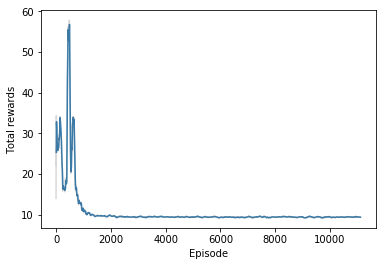

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.